# Cardamom Price Forecasting Framework

Multi-horizon forecasting with regime change prediction, built on structural insights.

| Horizon | Model | Key Features |
|---------|-------|-------------|
| **7-day** | LightGBM | Price momentum, RSI, volume patterns |
| **14-day** | LightGBM | + Calendar/seasonal, festival flags |
| **28-day** | LightGBM + Ridge Stack | + Weather, ENSO, macro, Guatemala supply |
| **90-day** | Bayesian Ridge + Quantile | Structural forces only: cost floor, ENSO lag12m, cobweb cycle |
| **Regime** | GBM Classifier | Cycle age, ENSO, Guatemala supply, price/cost ratio |

All models use **walk-forward cross-validation** (no random splits).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             roc_auc_score, classification_report, precision_recall_curve)
from sklearn.feature_selection import RFECV
# Using sklearn GradientBoosting (LightGBM needs libomp)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 110

CONFIG = {
    'horizons': {
        '7d':  {'shift': 7,  'gran': 'daily'},
        '14d': {'shift': 14, 'gran': 'daily'},
        '28d': {'shift': 4,  'gran': 'weekly'},
        '90d': {'shift': 3,  'gran': 'monthly'},
    },
    'wf': {  # walk-forward params
        'daily':   {'min_train': 500, 'step': 120, 'eval': 120},
        'weekly':  {'min_train': 104, 'step': 13,  'eval': 13},
        'monthly': {'min_train': 48,  'step': 6,   'eval': 6},
    }
}
print('Libraries loaded. Using sklearn GradientBoosting.')

Libraries loaded. Using sklearn GradientBoosting.


In [2]:
# === Helper Functions ===

def load_yf(path, name):
    raw = pd.read_csv(path, header=None, skiprows=3)
    raw.columns = ['Date','Close','High','Low','Open','Volume']
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw = raw[['Date','Close']].rename(columns={'Close': name})
    raw[name] = pd.to_numeric(raw[name], errors='coerce')
    return raw.dropna().sort_values('Date').drop_duplicates('Date')

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def walk_forward_splits(n, min_train, step, eval_win, purge=0):
    splits = []
    start = min_train + purge
    while start + eval_win <= n:
        train_end = start - purge
        test_start = start
        test_end = min(start + eval_win, n)
        splits.append((list(range(0, train_end)), list(range(test_start, test_end))))
        start += step
    return splits

def eval_metrics(y_true, y_pred, y_prev=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true.clip(lower=1))) * 100
    r2 = r2_score(y_true, y_pred)
    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
    if y_prev is not None:
        actual_dir = np.sign(y_true.values - y_prev.values)
        pred_dir = np.sign(y_pred - y_prev.values)
        metrics['DirAcc'] = np.mean(actual_dir == pred_dir) * 100
    return metrics

print('Helper functions defined.')

Helper functions defined.


---
## Section 1: Data Loading & Merging

In [3]:
# === Load auction data ===
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Date', 'AvgPrice']).reset_index(drop=True)

daily = df.groupby('Date').agg(
    Lots=('Lots', 'sum'),
    Arrived=('Qty_Arrived_Kg', 'sum'),
    Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    AvgPrice=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    NumAuctions=('Auctioneer', 'nunique')
).reset_index().sort_values('Date').reset_index(drop=True)
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)
print(f'Daily auction data: {len(daily)} rows, {daily["Date"].min().date()} to {daily["Date"].max().date()}')

Daily auction data: 3028 rows, 2014-11-07 to 2026-02-06


In [4]:
# === Load all external data ===
weather = pd.read_csv('external_idukki_weather.csv', parse_dates=['Date'])
gt_weather = pd.read_csv('external_guatemala_weather.csv', parse_dates=['Date'])
usdinr = load_yf('external_usdinr.csv', 'USDINR')
oil = load_yf('external_crude_oil.csv', 'CrudeOil')
gold = load_yf('external_gold.csv', 'Gold')
nifty = load_yf('external_nifty50.csv', 'Nifty')

oni_raw = pd.read_csv('external_enso_oni.csv')
stm = {'DJF':1,'JFM':2,'FMA':3,'MAM':4,'AMJ':5,'MJJ':6,'JJA':7,'JAS':8,'ASO':9,'SON':10,'OND':11,'NDJ':12}
oni_raw['month'] = oni_raw['SEAS'].map(stm)
oni_raw['Date'] = pd.to_datetime(oni_raw['YR'].astype(str)+'-'+oni_raw['month'].astype(str)+'-15')
oni = oni_raw[['Date','ANOM']].rename(columns={'ANOM':'ENSO'}).set_index('Date').resample('D').ffill().reset_index()

festivals = pd.read_csv('external_festival_calendar.csv', parse_dates=['Date'])

gt_exp = pd.read_csv('external_guatemala_monthly_exports.csv')
gt_exp['Date'] = pd.to_datetime(gt_exp['period'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
gt_exp['qty_best'] = gt_exp.apply(lambda r: r['netWgt_kg'] if r['qty_kg']==0 else r['qty_kg'], axis=1)

sa_imp = pd.read_csv('external_saudi_monthly_imports.csv')
sa_imp['Date'] = pd.to_datetime(sa_imp['period'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)

trends = pd.read_csv('external_google_trends_cardamom.csv', parse_dates=['date'])
trends['Date'] = trends['date'] + pd.offsets.MonthEnd(0)

print('External data loaded:')
for name, d in [('Weather', weather), ('Guatemala Weather', gt_weather), ('USDINR', usdinr),
                ('Oil', oil), ('Gold', gold), ('Nifty', nifty), ('ENSO', oni),
                ('Festivals', festivals), ('Guatemala Exports', gt_exp),
                ('Saudi Imports', sa_imp), ('Google Trends', trends)]:
    print(f'  {name:20s}: {len(d):>5} rows')

External data loaded:
  Weather             :  4420 rows
  Guatemala Weather   :  4420 rows
  USDINR              :  2932 rows
  Oil                 :  2833 rows
  Gold                :  2831 rows
  Nifty               :  2773 rows
  ENSO                : 27729 rows
  Festivals           :  4748 rows
  Guatemala Exports   :   124 rows
  Saudi Imports       :   124 rows
  Google Trends       :   144 rows


In [5]:
# === Merge & create multi-granularity datasets ===

# Daily merge
d = daily.copy()
d = d.merge(weather, on='Date', how='left')
d = d.merge(gt_weather, on='Date', how='left')
for ext in [usdinr, oil, gold, nifty]:
    d = d.merge(ext, on='Date', how='left')
d = d.merge(oni, on='Date', how='left')
d = d.merge(festivals, on='Date', how='left')
# Forward-fill financial & ENSO data
for col in ['USDINR','CrudeOil','Gold','Nifty','ENSO']:
    d[col] = d[col].ffill()
d = d.ffill().bfill()

# Weekly aggregation
di = d.set_index('Date')
weekly = pd.DataFrame()
weekly['AvgPrice'] = di['AvgPrice'].resample('W-FRI').mean()
weekly['Sold'] = di['Sold'].resample('W-FRI').sum()
weekly['Arrived'] = di['Arrived'].resample('W-FRI').sum()
weekly['MaxPrice'] = di['MaxPrice'].resample('W-FRI').max()
weekly['rain_mm'] = di['rain_mm'].resample('W-FRI').sum()
weekly['gt_rain_mm'] = di['gt_rain_mm'].resample('W-FRI').sum()
for col in ['USDINR','CrudeOil','Gold','Nifty','ENSO','temp_max_c','humidity_pct']:
    if col in di.columns:
        weekly[col] = di[col].resample('W-FRI').last()
for col in festivals.columns[1:]:
    if col in di.columns:
        weekly[col] = di[col].resample('W-FRI').max()
weekly = weekly.dropna(subset=['AvgPrice']).reset_index()

# Monthly aggregation
monthly = pd.DataFrame()
monthly['AvgPrice'] = di['AvgPrice'].resample('ME').mean()
monthly['Sold'] = di['Sold'].resample('ME').sum()
monthly['Arrived'] = di['Arrived'].resample('ME').sum()
monthly['MaxPrice'] = di['MaxPrice'].resample('ME').max()
monthly['rain_mm'] = di['rain_mm'].resample('ME').sum()
monthly['gt_rain_mm'] = di['gt_rain_mm'].resample('ME').sum()
for col in ['USDINR','CrudeOil','Gold','Nifty','ENSO','temp_max_c','humidity_pct']:
    if col in di.columns:
        monthly[col] = di[col].resample('ME').last()
monthly = monthly.dropna(subset=['AvgPrice']).reset_index()

# Merge monthly trade data onto monthly
monthly = monthly.merge(
    gt_exp[['Date','qty_best','value_usd']].rename(columns={'qty_best':'gt_qty_kg','value_usd':'gt_value_usd'}),
    on='Date', how='left')
monthly = monthly.merge(
    sa_imp[['Date','netWgt_kg','value_usd']].rename(columns={'netWgt_kg':'sa_qty_kg','value_usd':'sa_value_usd'}),
    on='Date', how='left')
monthly = monthly.merge(
    trends[['Date','cardamom_price','elaichi_price','cardamom_plantation']],
    on='Date', how='left')

# Also merge monthly trade onto weekly via merge_asof
gt_monthly = gt_exp[['Date','qty_best','value_usd']].rename(columns={'qty_best':'gt_qty_kg','value_usd':'gt_value_usd'}).sort_values('Date')
sa_monthly = sa_imp[['Date','netWgt_kg','value_usd']].rename(columns={'netWgt_kg':'sa_qty_kg','value_usd':'sa_value_usd'}).sort_values('Date')
weekly = weekly.sort_values('Date')
weekly = pd.merge_asof(weekly, gt_monthly, on='Date', direction='backward')
weekly = pd.merge_asof(weekly, sa_monthly, on='Date', direction='backward')

print(f'Daily:   {len(d)} rows')
print(f'Weekly:  {len(weekly)} rows')
print(f'Monthly: {len(monthly)} rows')

Daily:   3028 rows
Weekly:  546 rows
Monthly: 130 rows


---
## Section 2: Feature Engineering

6 tiers of features, applied at appropriate granularities per horizon.

In [6]:
# === Tier 1: Technical/Momentum ===

def add_tier1(df, price_col='AvgPrice', vol_col='Sold', arr_col='Arrived', max_col='MaxPrice'):
    p = df[price_col].copy()
    feats = []
    
    # Price lags
    for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
        col = f'lag_{lag}'
        df[col] = p.shift(lag)
        feats.append(col)
    
    # Rolling stats
    for w in [7, 14, 30, 60, 90]:
        col = f'ma_{w}'
        df[col] = p.shift(1).rolling(w, min_periods=max(1,w//2)).mean()
        feats.append(col)
    for w in [7, 14, 30]:
        col = f'std_{w}'
        df[col] = p.shift(1).rolling(w, min_periods=max(1,w//2)).std()
        feats.append(col)
    for w in [14, 30]:
        df[f'min_{w}'] = p.shift(1).rolling(w).min()
        df[f'max_{w}'] = p.shift(1).rolling(w).max()
        feats += [f'min_{w}', f'max_{w}']
    
    # Momentum
    for w in [7, 14, 30]:
        df[f'pct_{w}'] = p.shift(1).pct_change(w) * 100
        feats.append(f'pct_{w}')
    
    # RSI
    df['rsi_14'] = compute_rsi(p.shift(1), 14)
    feats.append('rsi_14')
    
    # Bollinger position
    df['boll_pos'] = (p.shift(1) - df['ma_30']) / (2 * df['std_30'].clip(lower=0.01))
    feats.append('boll_pos')
    
    # Mean reversion
    df['price_vs_ma30'] = p.shift(1) / df['ma_30'] - 1
    df['price_vs_ma90'] = p.shift(1) / df['ma_90'] - 1
    feats += ['price_vs_ma30', 'price_vs_ma90']
    
    # Volume features
    if vol_col in df.columns:
        v = df[vol_col].copy()
        for w in [7, 14, 30]:
            df[f'vol_ma_{w}'] = v.shift(1).rolling(w, min_periods=max(1,w//2)).mean()
            feats.append(f'vol_ma_{w}')
        df['vol_ratio'] = v.shift(1) / df['vol_ma_30'].clip(lower=1)
        feats.append('vol_ratio')
        
        if arr_col in df.columns:
            df['sell_through_14'] = v.shift(1).rolling(14).sum() / df[arr_col].shift(1).rolling(14).sum().clip(lower=1)
            feats.append('sell_through_14')
    
    if max_col in df.columns:
        df['max_avg_spread'] = df[max_col].shift(1) / p.shift(1) - 1
        feats.append('max_avg_spread')
    
    return feats

# Apply to daily
T1_DAILY = add_tier1(d)
# Apply to weekly (smaller windows)
T1_WEEKLY = add_tier1(weekly)
# Apply to monthly
T1_MONTHLY = add_tier1(monthly)

print(f'Tier 1 features: Daily={len(T1_DAILY)}, Weekly={len(T1_WEEKLY)}, Monthly={len(T1_MONTHLY)}')

Tier 1 features: Daily=33, Weekly=33, Monthly=33


In [7]:
# === Tier 2: Calendar/Seasonal ===

def add_tier2(df):
    feats = []
    df['month_sin'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)
    feats += ['month_sin', 'month_cos']
    
    if len(df) > 100:  # daily or weekly
        df['week_sin'] = np.sin(2 * np.pi * df['Date'].dt.isocalendar().week.astype(int) / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['Date'].dt.isocalendar().week.astype(int) / 52)
        feats += ['week_sin', 'week_cos']
    
    # Festival flags (already merged for daily, re-derive for weekly/monthly)
    for col in ['wedding_season','harvest_season','peak_harvest','pre_eid_period',
                'pre_diwali_period','pre_onam_period','xmas_newyear']:
        if col in df.columns:
            feats.append(col)
    
    # Derived seasonal
    m = df['Date'].dt.month
    df['is_lean'] = ((m >= 3) & (m <= 5)).astype(int)
    df['is_strong'] = (m.isin([8, 9, 12, 1])).astype(int)
    feats += ['is_lean', 'is_strong']
    
    return feats

T2_DAILY = add_tier2(d)
T2_WEEKLY = add_tier2(weekly)
T2_MONTHLY = add_tier2(monthly)
print(f'Tier 2 features: Daily={len(T2_DAILY)}, Weekly={len(T2_WEEKLY)}, Monthly={len(T2_MONTHLY)}')

Tier 2 features: Daily=13, Weekly=13, Monthly=6


In [8]:
# === Tier 3: Weather/ENSO ===

def add_tier3(df):
    feats = []
    # Cumulative rainfall
    if 'rain_mm' in df.columns:
        for w in [28, 56, 91, 182]:
            col = f'rain_cum_{w}'
            df[col] = df['rain_mm'].shift(1).rolling(w, min_periods=w//2).sum()
            feats.append(col)
        df['rain_anomaly'] = df['rain_mm'].shift(1).rolling(28).sum() - df['rain_mm'].shift(1).rolling(365, min_periods=180).mean() * (28/365)
        feats.append('rain_anomaly')
    
    if 'gt_rain_mm' in df.columns:
        for w in [28, 91, 182]:
            col = f'gt_rain_cum_{w}'
            df[col] = df['gt_rain_mm'].shift(1).rolling(w, min_periods=w//2).sum()
            feats.append(col)
    
    if 'temp_max_c' in df.columns:
        df['temp_ma_28'] = df['temp_max_c'].shift(1).rolling(28, min_periods=14).mean()
        feats.append('temp_ma_28')
    
    if 'humidity_pct' in df.columns:
        df['humidity_ma_28'] = df['humidity_pct'].shift(1).rolling(28, min_periods=14).mean()
        feats.append('humidity_ma_28')
    
    # ENSO
    if 'ENSO' in df.columns:
        df['enso'] = df['ENSO'].shift(1)
        feats.append('enso')
        # Lagged ENSO (6 and 12 months)
        if len(df) > 200:
            df['enso_lag6m'] = df['ENSO'].shift(182)  # ~6 months in days
            df['enso_lag12m'] = df['ENSO'].shift(365)  # ~12 months
            feats += ['enso_lag6m', 'enso_lag12m']
        else:
            # For monthly data
            df['enso_lag6m'] = df['ENSO'].shift(6)
            df['enso_lag12m'] = df['ENSO'].shift(12)
            feats += ['enso_lag6m', 'enso_lag12m']
        # ENSO phase
        df['enso_phase'] = 0  # neutral
        df.loc[df['enso'] > 0.5, 'enso_phase'] = 1   # El Nino
        df.loc[df['enso'] < -0.5, 'enso_phase'] = -1  # La Nina
        feats.append('enso_phase')
    
    return feats

T3_DAILY = add_tier3(d)
T3_WEEKLY = add_tier3(weekly)
T3_MONTHLY = add_tier3(monthly)
print(f'Tier 3 features: Daily={len(T3_DAILY)}, Weekly={len(T3_WEEKLY)}, Monthly={len(T3_MONTHLY)}')

Tier 3 features: Daily=14, Weekly=14, Monthly=14


In [9]:
# === Tier 4: Macro ===

def add_tier4(df):
    feats = []
    if 'USDINR' in df.columns:
        df['usdinr_lvl'] = df['USDINR'].shift(1)
        feats.append('usdinr_lvl')
        for w in [28, 90]:
            col = f'usdinr_pct_{w}'
            df[col] = df['USDINR'].shift(1).pct_change(w) * 100
            feats.append(col)
    
    for name in ['CrudeOil', 'Gold', 'Nifty']:
        if name in df.columns:
            for w in [28]:
                col = f'{name.lower()}_pct_{w}'
                df[col] = df[name].shift(1).pct_change(w) * 100
                feats.append(col)
    return feats

T4_DAILY = add_tier4(d)
T4_WEEKLY = add_tier4(weekly)
T4_MONTHLY = add_tier4(monthly)
print(f'Tier 4 features: Daily={len(T4_DAILY)}, Weekly={len(T4_WEEKLY)}, Monthly={len(T4_MONTHLY)}')

Tier 4 features: Daily=6, Weekly=6, Monthly=6


In [10]:
# === Tier 5: Supply/Demand Trade ===
# Monthly trade data already merged via merge_asof onto weekly, direct merge onto monthly

def add_tier5(df):
    feats = []
    if 'gt_qty_kg' in df.columns:
        df['gt_qty_mt'] = df['gt_qty_kg'] / 1000
        df['gt_qty_3m'] = df['gt_qty_mt'].rolling(3, min_periods=1).sum()
        df['gt_qty_yoy'] = df['gt_qty_mt'].pct_change(12) * 100 if len(df) > 200 else df['gt_qty_mt'].pct_change(12) * 100
        df['gt_unit_price'] = df['gt_value_usd'] / df['gt_qty_kg'].clip(lower=1)
        feats += ['gt_qty_3m', 'gt_qty_yoy', 'gt_unit_price']
    
    if 'sa_qty_kg' in df.columns:
        df['sa_qty_mt'] = df['sa_qty_kg'] / 1000
        df['sa_qty_3m'] = df['sa_qty_mt'].rolling(3, min_periods=1).sum()
        df['sa_qty_yoy'] = df['sa_qty_mt'].pct_change(12) * 100
        feats += ['sa_qty_3m', 'sa_qty_yoy']
    
    return feats

T5_WEEKLY = add_tier5(weekly)
T5_MONTHLY = add_tier5(monthly)
T5_DAILY = []  # Not used for daily models
print(f'Tier 5 features: Weekly={len(T5_WEEKLY)}, Monthly={len(T5_MONTHLY)}')

Tier 5 features: Weekly=5, Monthly=5


In [11]:
# === Tier 6: Structural/Cycle ===

def add_tier6(df, price_col='AvgPrice'):
    feats = []
    
    # Cost floor from MGNREGA Kerala (5.2% CAGR from Rs.212 in 2014)
    base_wage = 212
    base_year = 2014
    cagr = 0.052
    years_from_base = (df['Date'] - pd.Timestamp(f'{base_year}-01-01')).dt.days / 365.25
    mgnrega_wage = base_wage * (1 + cagr) ** years_from_base
    cost_per_kg = mgnrega_wage * 1.7 * 200 / 0.62 / 350
    df['cost_floor'] = cost_per_kg
    df['price_to_cost'] = df[price_col].shift(1) / cost_per_kg
    feats += ['price_to_cost']
    
    # Cobweb cycle position: months since last price trough
    # Detect troughs: local min in 6-month smoothed price with >20% subsequent rise
    smoothed = df[price_col].rolling(min(180, len(df)//4), min_periods=30, center=True).mean()
    if len(df) > 24:
        # Simple trough detection: points where smoothed price is lower than surrounding 6 months
        troughs = []
        w = min(6, len(df)//6)
        for i in range(w, len(df)-w):
            window = smoothed.iloc[max(0,i-w):min(len(df),i+w+1)]
            if smoothed.iloc[i] == window.min() and not pd.isna(smoothed.iloc[i]):
                troughs.append(df['Date'].iloc[i])
        
        if troughs:
            df['months_since_trough'] = df['Date'].apply(
                lambda x: min([(x - t).days / 30.44 for t in troughs if t <= x], default=np.nan))
            df['cycle_age_norm'] = df['months_since_trough'] / 48  # 48 month avg cycle
            feats += ['months_since_trough', 'cycle_age_norm']
    
    # Google Trends (monthly only)
    if 'cardamom_plantation' in df.columns:
        df['gt_plantation_ma12'] = df['cardamom_plantation'].rolling(12, min_periods=6).mean()
        df['gt_price_interest'] = df['cardamom_price']
        feats += ['gt_plantation_ma12', 'gt_price_interest']
    
    # Volume vs 2-year avg
    if 'Sold' in df.columns and len(df) > 24:
        df['vol_vs_2yr'] = df['Sold'].shift(1).rolling(3, min_periods=1).mean() / df['Sold'].shift(1).rolling(24, min_periods=12).mean()
        feats.append('vol_vs_2yr')
    
    return feats

T6_MONTHLY = add_tier6(monthly)
T6_WEEKLY = add_tier6(weekly)
T6_DAILY = []
print(f'Tier 6 features: Monthly={len(T6_MONTHLY)}, Weekly={len(T6_WEEKLY)}')

Tier 6 features: Monthly=6, Weekly=4


In [12]:
# === Assemble feature sets per horizon + create targets ===

# Targets
for h in [7, 14]:
    d[f'target_{h}d'] = d['AvgPrice'].shift(-h)
weekly['target_4w'] = weekly['AvgPrice'].shift(-4)
monthly['target_3m'] = monthly['AvgPrice'].shift(-3)
# Regime target: >10% decline within 6 months
monthly['fwd_6m_ret'] = (monthly['AvgPrice'].shift(-6) / monthly['AvgPrice'] - 1) * 100
monthly['bear_signal'] = (monthly['fwd_6m_ret'] < -10).astype(int)

# Feature sets
FEATS_7D = T1_DAILY + T2_DAILY[:5]  # technical + basic calendar
FEATS_14D = T1_DAILY + T2_DAILY     # technical + full calendar
FEATS_28D = T1_WEEKLY + T2_WEEKLY + T3_WEEKLY + T4_WEEKLY + T5_WEEKLY
FEATS_90D = T1_MONTHLY[:10] + T2_MONTHLY[:2] + T3_MONTHLY[-5:] + T5_MONTHLY + T6_MONTHLY
FEATS_REGIME = T1_MONTHLY[:10] + T3_MONTHLY + T5_MONTHLY + T6_MONTHLY

# Print summary
for name, feats, df_check in [('7d', FEATS_7D, d), ('14d', FEATS_14D, d),
                               ('28d', FEATS_28D, weekly), ('90d', FEATS_90D, monthly),
                               ('Regime', FEATS_REGIME, monthly)]:
    valid = [f for f in feats if f in df_check.columns]
    print(f'{name:>6s}: {len(valid):>3d} features')
print()

# Prepare clean DataFrames (drop NaN rows)
def prepare(df, feats, target_col):
    valid_feats = [f for f in feats if f in df.columns]
    subset = df[['Date', 'AvgPrice'] + valid_feats + [target_col]].dropna()
    return subset, valid_feats

d7, F7 = prepare(d, FEATS_7D, 'target_7d')
d14, F14 = prepare(d, FEATS_14D, 'target_14d')
d28, F28 = prepare(weekly, FEATS_28D, 'target_4w')
d90, F90 = prepare(monthly, FEATS_90D, 'target_3m')

# Regime
regime_feats = [f for f in FEATS_REGIME if f in monthly.columns]
d_regime = monthly[['Date', 'AvgPrice'] + regime_feats + ['bear_signal']].dropna(subset=['bear_signal'])  # only require target, impute features

print(f'\nPrepared datasets:')
print(f'  7-day:  {len(d7)} rows, {len(F7)} features')
print(f'  14-day: {len(d14)} rows, {len(F14)} features')
print(f'  28-day: {len(d28)} rows, {len(F28)} features')
print(f'  90-day: {len(d90)} rows, {len(F90)} features')
print(f'  Regime: {len(d_regime)} rows, {len(regime_feats)} features, {d_regime["bear_signal"].sum()} bear months ({d_regime["bear_signal"].mean()*100:.0f}%)')

    7d:  38 features
   14d:  46 features
   28d:  71 features
   90d:  28 features
Regime:  35 features


Prepared datasets:
  7-day:  2976 rows, 38 features
  14-day: 2969 rows, 46 features
  28-day: 177 rows, 71 features
  90-day: 79 rows, 28 features
  Regime: 130 rows, 35 features, 41 bear months (32%)


---
## Section 3: Walk-Forward Cross-Validation

In [13]:
# === Walk-forward infrastructure ===

def run_walk_forward(df, features, target_col, model_fn, min_train, step, eval_win, purge=0, prev_col=None):
    """Run walk-forward CV and return results."""
    n = len(df)
    splits = walk_forward_splits(n, min_train, step, eval_win, purge)
    
    results = []
    all_preds = []
    
    for fold_i, (train_idx, test_idx) in enumerate(splits):
        X_train = df.iloc[train_idx][features].values
        y_train = df.iloc[train_idx][target_col].values
        X_test = df.iloc[test_idx][features].values
        y_test = df.iloc[test_idx][target_col].values
        
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        y_prev = df.iloc[test_idx]['AvgPrice'] if prev_col is None else df.iloc[test_idx][prev_col]
        metrics = eval_metrics(pd.Series(y_test), y_pred, y_prev if prev_col is None else pd.Series(y_prev.values))
        metrics['fold'] = fold_i
        metrics['test_start'] = df.iloc[test_idx[0]]['Date']
        metrics['test_end'] = df.iloc[test_idx[-1]]['Date']
        metrics['train_size'] = len(train_idx)
        results.append(metrics)
        
        fold_preds = pd.DataFrame({
            'Date': df.iloc[test_idx]['Date'].values,
            'Actual': y_test,
            'Predicted': y_pred,
            'fold': fold_i
        })
        all_preds.append(fold_preds)
    
    results_df = pd.DataFrame(results)
    preds_df = pd.concat(all_preds, ignore_index=True)
    return results_df, preds_df, model  # last model returned for inspection

# Baseline: persistence (predict last known price)
def persistence_baseline(df, target_col, shift):
    """Simple baseline: forecast = current price."""
    y_true = df[target_col].dropna()
    y_pred = df['AvgPrice'].iloc[:len(y_true)]
    return eval_metrics(y_true, y_pred.values, y_pred)

print('Walk-forward CV infrastructure ready.')
print(f'\nFold counts:')
for name, n, cfg_key in [('7d daily', len(d7), 'daily'), ('14d daily', len(d14), 'daily'),
                          ('28d weekly', len(d28), 'weekly'), ('90d monthly', len(d90), 'monthly')]:
    cfg = CONFIG['wf'][cfg_key]
    splits = walk_forward_splits(n, cfg['min_train'], cfg['step'], cfg['eval'])
    print(f'  {name}: {len(splits)} folds')

Walk-forward CV infrastructure ready.

Fold counts:
  7d daily: 20 folds
  14d daily: 20 folds
  28d weekly: 5 folds
  90d monthly: 5 folds


---
## Section 4: Tier A — 7-day & 14-day Forecasts (LightGBM)

In [14]:
# === 7-day LightGBM ===
def lgb_7d():
    return GradientBoostingRegressor(
        n_estimators=100, max_depth=4, learning_rate=0.1,
        subsample=0.8, min_samples_leaf=10, random_state=42)

cfg = CONFIG['wf']['daily']
res_7d, preds_7d, model_7d = run_walk_forward(d7, F7, 'target_7d', lgb_7d,
                                               cfg['min_train'], cfg['step'], cfg['eval'], purge=7)

print('7-DAY FORECAST — Walk-Forward Results')
print('='*70)
print(f'{"Fold":>4} {"Period":>25} {"MAE":>8} {"MAPE%":>8} {"DirAcc%":>8} {"R²":>8}')
print('-'*70)
for _, r in res_7d.iterrows():
    print(f'{int(r["fold"]):>4} {str(r["test_start"].date()):>12}-{str(r["test_end"].date()):>12} {r["MAE"]:>8.1f} {r["MAPE"]:>8.1f} {r.get("DirAcc",0):>8.1f} {r["R2"]:>8.3f}')
print('-'*70)
print(f'{"AVG":>4} {"":>25} {res_7d["MAE"].mean():>8.1f} {res_7d["MAPE"].mean():>8.1f} {res_7d.get("DirAcc",pd.Series([0])).mean():>8.1f} {res_7d["R2"].mean():>8.3f}')

7-DAY FORECAST — Walk-Forward Results
Fold                    Period      MAE    MAPE%  DirAcc%       R²
----------------------------------------------------------------------
   0   2017-04-19-  2017-09-09     66.3      6.7     60.0    0.343
   1   2017-09-11-  2018-02-05    191.3     21.1     55.0   -8.704
   2   2018-02-06-  2018-07-04     84.8      9.6     48.3   -1.279
   3   2018-07-05-  2018-12-07     84.0      7.0     56.7    0.085
   4   2018-12-08-  2019-05-08    336.9     17.6     39.2   -0.979
   5   2019-05-09-  2019-10-10    607.3     18.0     45.8   -1.210
   6   2019-10-11-  2020-02-29    460.9     14.1     65.8   -0.420
   7   2020-03-02-  2020-10-19    727.1     46.7     43.3   -8.253
   8   2020-10-20-  2021-03-13    133.2      8.8     50.0   -0.361
   9   2021-03-15-  2021-11-02     91.8      8.6     53.3   -0.481
  10   2021-11-03-  2022-03-26     42.0      4.5     59.2    0.239
  11   2022-03-28-  2022-08-18     43.6      5.0     61.7    0.446
  12   2022-08-19-  

In [15]:
# === 14-day LightGBM ===
def lgb_14d():
    return GradientBoostingRegressor(
        n_estimators=100, max_depth=4, learning_rate=0.08,
        subsample=0.8, min_samples_leaf=15, random_state=42)

res_14d, preds_14d, model_14d = run_walk_forward(d14, F14, 'target_14d', lgb_14d,
                                                   cfg['min_train'], cfg['step'], cfg['eval'], purge=14)

print('14-DAY FORECAST — Walk-Forward Results')
print('='*70)
print(f'{"Fold":>4} {"Period":>25} {"MAE":>8} {"MAPE%":>8} {"DirAcc%":>8} {"R²":>8}')
print('-'*70)
for _, r in res_14d.iterrows():
    print(f'{int(r["fold"]):>4} {str(r["test_start"].date()):>12}-{str(r["test_end"].date()):>12} {r["MAE"]:>8.1f} {r["MAPE"]:>8.1f} {r.get("DirAcc",0):>8.1f} {r["R2"]:>8.3f}')
print('-'*70)
print(f'{"AVG":>4} {"":>25} {res_14d["MAE"].mean():>8.1f} {res_14d["MAPE"].mean():>8.1f} {res_14d.get("DirAcc",pd.Series([0])).mean():>8.1f} {res_14d["R2"].mean():>8.3f}')

14-DAY FORECAST — Walk-Forward Results
Fold                    Period      MAE    MAPE%  DirAcc%       R²
----------------------------------------------------------------------
   0   2017-04-27-  2017-09-18     82.8      8.1     55.8   -0.012
   1   2017-09-19-  2018-02-13    274.2     30.0     48.3  -24.708
   2   2018-02-14-  2018-07-13    101.0     11.4     45.8   -1.275
   3   2018-07-14-  2018-12-15    102.9      8.4     65.8   -0.984
   4   2018-12-17-  2019-05-16    497.9     24.6     30.8   -1.542
   5   2019-05-17-  2019-10-18    648.6     19.2     52.5   -1.534
   6   2019-10-19-  2020-03-09    709.2     23.4     50.0   -1.219
   7   2020-03-10-  2020-10-27    872.9     57.0     34.2  -36.954
   8   2020-10-28-  2021-03-23    184.8     12.3     40.8   -1.102
   9   2021-03-24-  2021-11-11    117.6     11.4     56.7   -9.837
  10   2021-11-12-  2022-04-04     43.4      4.7     65.8   -1.050
  11   2022-04-05-  2022-08-26     65.1      7.4     56.7   -0.029
  12   2022-08-27- 

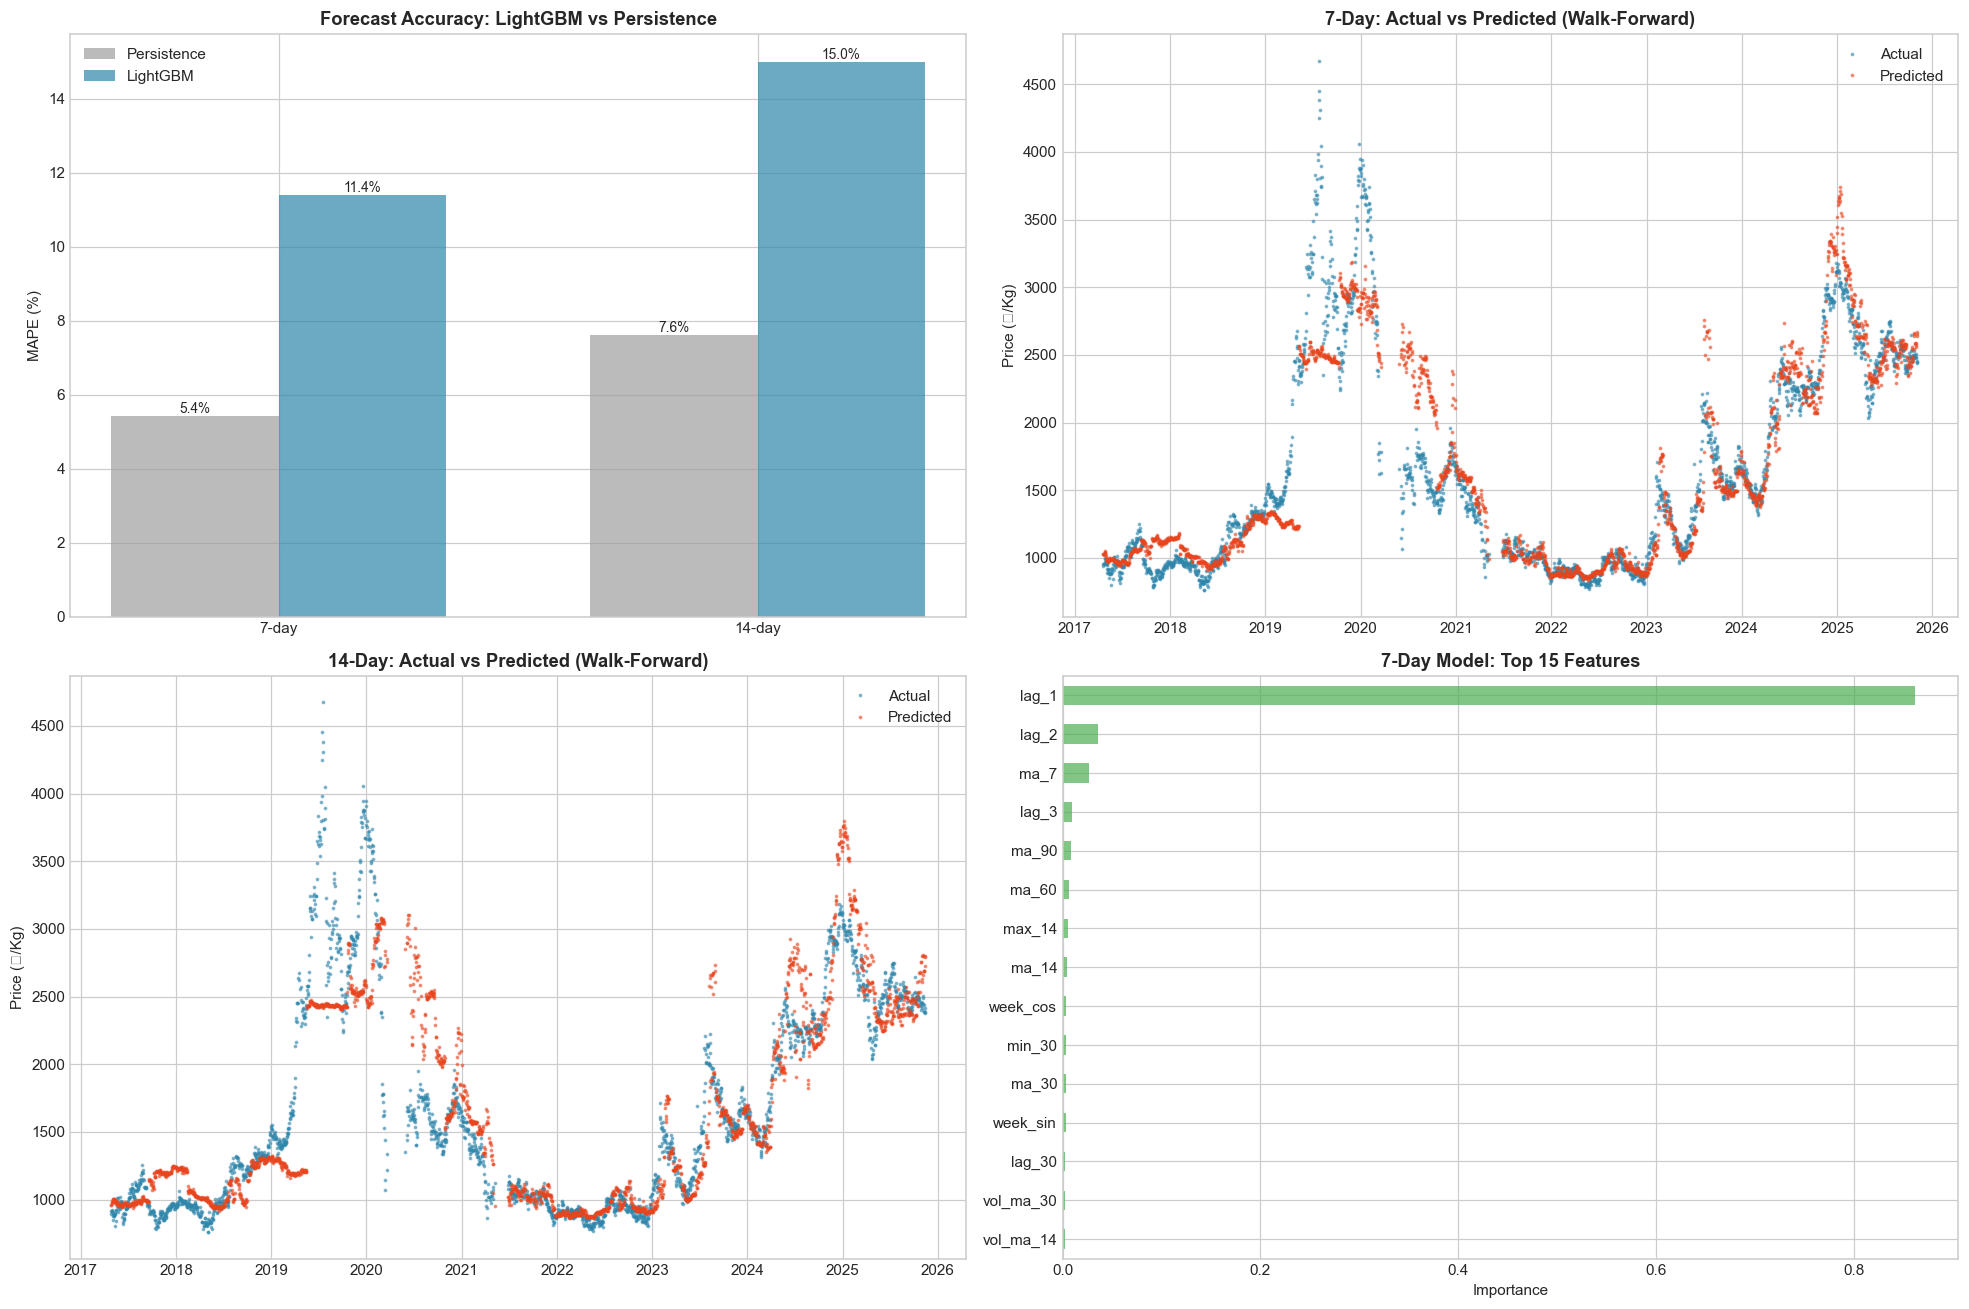

In [16]:
# === Tier A: Results + Baselines ===

# Persistence baselines
base_7 = persistence_baseline(d7, 'target_7d', 7)
base_14 = persistence_baseline(d14, 'target_14d', 14)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Metrics comparison
ax = axes[0, 0]
metrics_comp = pd.DataFrame({
    'Model': ['Persistence', 'LightGBM', 'Persistence', 'LightGBM'],
    'Horizon': ['7-day','7-day','14-day','14-day'],
    'MAPE': [base_7['MAPE'], res_7d['MAPE'].mean(), base_14['MAPE'], res_14d['MAPE'].mean()]
})
x = np.arange(2)
w = 0.35
ax.bar(x - w/2, [base_7['MAPE'], base_14['MAPE']], w, label='Persistence', color='#9E9E9E', alpha=0.7)
ax.bar(x + w/2, [res_7d['MAPE'].mean(), res_14d['MAPE'].mean()], w, label='LightGBM', color='#2E86AB', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(['7-day', '14-day'])
ax.set_ylabel('MAPE (%)')
ax.set_title('Forecast Accuracy: LightGBM vs Persistence', fontweight='bold')
ax.legend()
for i, (b, m) in enumerate([(base_7['MAPE'], res_7d['MAPE'].mean()), (base_14['MAPE'], res_14d['MAPE'].mean())]):
    ax.annotate(f'{b:.1f}%', xy=(i-w/2, b), ha='center', va='bottom', fontsize=9)
    ax.annotate(f'{m:.1f}%', xy=(i+w/2, m), ha='center', va='bottom', fontsize=9)

# Actual vs Predicted for 7d
ax = axes[0, 1]
ax.plot(preds_7d['Date'], preds_7d['Actual'], '.', color='#2E86AB', markersize=3, alpha=0.5, label='Actual')
ax.plot(preds_7d['Date'], preds_7d['Predicted'], '.', color='#E8451E', markersize=3, alpha=0.5, label='Predicted')
ax.set_title('7-Day: Actual vs Predicted (Walk-Forward)', fontweight='bold')
ax.legend()
ax.set_ylabel('Price (₹/Kg)')

# Actual vs Predicted for 14d
ax = axes[1, 0]
ax.plot(preds_14d['Date'], preds_14d['Actual'], '.', color='#2E86AB', markersize=3, alpha=0.5, label='Actual')
ax.plot(preds_14d['Date'], preds_14d['Predicted'], '.', color='#E8451E', markersize=3, alpha=0.5, label='Predicted')
ax.set_title('14-Day: Actual vs Predicted (Walk-Forward)', fontweight='bold')
ax.legend()
ax.set_ylabel('Price (₹/Kg)')

# Feature importance
ax = axes[1, 1]
imp = pd.Series(model_7d.feature_importances_, index=F7).sort_values(ascending=True).tail(15)
imp.plot.barh(ax=ax, color='#4CAF50', alpha=0.7)
ax.set_title('7-Day Model: Top 15 Features', fontweight='bold')
ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

---
## Section 5: Tier B — 28-day Forecast (Stacked LightGBM + Ridge)

In [17]:
# === Feature selection via RFE ===
# Use first 80% for selection to avoid lookahead
n_sel = int(len(d28) * 0.8)
X_sel = d28.iloc[:n_sel][F28].values
y_sel = d28.iloc[:n_sel]['target_4w'].values

# Quick RFE with LightGBM
selector = RFECV(
    GradientBoostingRegressor(n_estimators=30, max_depth=3, learning_rate=0.1, random_state=42),
    step=3, cv=3, scoring='neg_mean_absolute_error', min_features_to_select=10
)
# Handle any remaining NaN
mask = ~np.isnan(X_sel).any(axis=1) & ~np.isnan(y_sel)
selector.fit(X_sel[mask], y_sel[mask])

selected_mask = selector.support_
F28_SEL = [f for f, s in zip(F28, selected_mask) if s]
print(f'Feature selection: {len(F28)} → {len(F28_SEL)} features')
print(f'Selected: {F28_SEL}')

Feature selection: 71 → 62 features
Selected: ['lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_21', 'lag_30', 'ma_7', 'ma_14', 'ma_30', 'ma_60', 'ma_90', 'std_7', 'std_14', 'std_30', 'min_14', 'max_14', 'min_30', 'max_30', 'pct_7', 'pct_14', 'pct_30', 'rsi_14', 'price_vs_ma90', 'vol_ma_7', 'vol_ma_14', 'vol_ma_30', 'vol_ratio', 'sell_through_14', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'harvest_season', 'peak_harvest', 'pre_onam_period', 'xmas_newyear', 'is_lean', 'is_strong', 'rain_cum_28', 'rain_cum_56', 'rain_cum_91', 'rain_cum_182', 'rain_anomaly', 'gt_rain_cum_28', 'gt_rain_cum_91', 'gt_rain_cum_182', 'temp_ma_28', 'humidity_ma_28', 'enso', 'enso_lag6m', 'enso_phase', 'usdinr_lvl', 'usdinr_pct_28', 'usdinr_pct_90', 'crudeoil_pct_28', 'gold_pct_28', 'nifty_pct_28', 'gt_qty_3m', 'gt_qty_yoy', 'gt_unit_price', 'sa_qty_3m', 'sa_qty_yoy']


In [18]:
# === 28-day Stacked Ensemble ===
cfg_w = CONFIG['wf']['weekly']
splits_28 = walk_forward_splits(len(d28), cfg_w['min_train'], cfg_w['step'], cfg_w['eval'], purge=4)

all_results_28 = []
all_preds_28 = []

for fold_i, (train_idx, test_idx) in enumerate(splits_28):
    X_train = d28.iloc[train_idx][F28_SEL].values
    y_train = d28.iloc[train_idx]['target_4w'].values
    X_test = d28.iloc[test_idx][F28_SEL].values
    y_test = d28.iloc[test_idx]['target_4w'].values
    
    # Handle NaN
    train_mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    test_mask = ~np.isnan(X_test).any(axis=1) & ~np.isnan(y_test)
    X_tr, y_tr = X_train[train_mask], y_train[train_mask]
    X_te, y_te = X_test[test_mask], y_test[test_mask]
    
    if len(X_te) < 3:
        continue
    
    # Component 1: LightGBM
    m_lgb = GradientBoostingRegressor(n_estimators=80, max_depth=3, learning_rate=0.1,
                               subsample=0.8, min_samples_leaf=10, random_state=42)
    m_lgb.fit(X_tr, y_tr)
    p_lgb = m_lgb.predict(X_te)
    
    # Component 2: Ridge
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    m_ridge = Ridge(alpha=10.0)
    m_ridge.fit(X_tr_s, y_tr)
    p_ridge = m_ridge.predict(X_te_s)
    
    # Stack: simple average (more robust than meta-learner with few folds)
    p_stack = 0.6 * p_lgb + 0.4 * p_ridge
    
    test_rows = [test_idx[j] for j in range(len(test_idx)) if test_mask[j]]
    y_prev = d28.iloc[test_rows]['AvgPrice']
    
    metrics = eval_metrics(pd.Series(y_te), p_stack, pd.Series(y_prev.values))
    metrics['fold'] = fold_i
    metrics['test_start'] = d28.iloc[test_idx[0]]['Date']
    all_results_28.append(metrics)
    
    all_preds_28.append(pd.DataFrame({
        'Date': d28.iloc[test_rows]['Date'].values,
        'Actual': y_te, 'LGB': p_lgb, 'Ridge': p_ridge, 'Stack': p_stack, 'fold': fold_i
    }))

res_28 = pd.DataFrame(all_results_28)
preds_28 = pd.concat(all_preds_28, ignore_index=True) if all_preds_28 else pd.DataFrame()

print('28-DAY FORECAST — Walk-Forward Results (Stacked Ensemble)')
print('='*70)
if len(res_28) > 0:
    print(f'{"Fold":>4} {"Period":>15} {"MAE":>8} {"MAPE%":>8} {"DirAcc%":>8} {"R²":>8}')
    print('-'*70)
    for _, r in res_28.iterrows():
        print(f'{int(r["fold"]):>4} {str(r["test_start"].date()):>15} {r["MAE"]:>8.1f} {r["MAPE"]:>8.1f} {r.get("DirAcc",0):>8.1f} {r["R2"]:>8.3f}')
    print('-'*70)
    print(f'{"AVG":>4} {"":>15} {res_28["MAE"].mean():>8.1f} {res_28["MAPE"].mean():>8.1f} {res_28.get("DirAcc",pd.Series([0])).mean():>8.1f} {res_28["R2"].mean():>8.3f}')

28-DAY FORECAST — Walk-Forward Results (Stacked Ensemble)
Fold          Period      MAE    MAPE%  DirAcc%       R²
----------------------------------------------------------------------
   0      2024-09-20    753.3     26.6     23.1   -6.830
   1      2024-12-20    127.2      4.4     84.6    0.230
   2      2025-03-21    379.8     16.4     53.8   -6.647
   3      2025-06-20    146.6      5.8     46.2   -1.873
   4      2025-09-19    173.8      7.1     46.2  -17.955
----------------------------------------------------------------------
 AVG                    316.1     12.1     50.8   -6.615


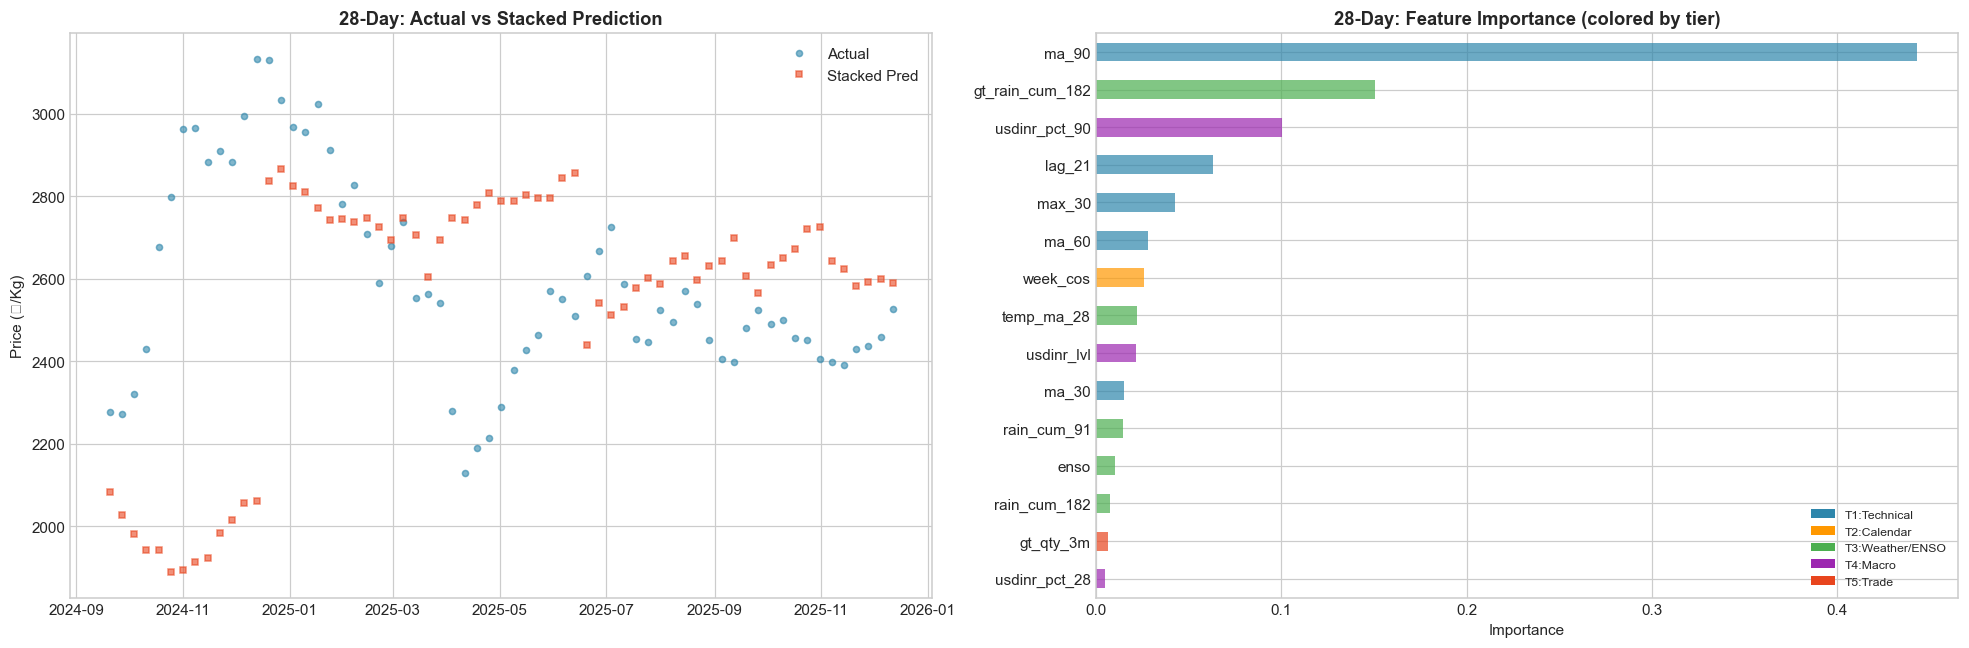

In [19]:
# === 28-day Results Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

if len(preds_28) > 0:
    ax = axes[0]
    ax.plot(preds_28['Date'], preds_28['Actual'], 'o', color='#2E86AB', markersize=4, alpha=0.6, label='Actual')
    ax.plot(preds_28['Date'], preds_28['Stack'], 's', color='#E8451E', markersize=4, alpha=0.6, label='Stacked Pred')
    ax.set_title('28-Day: Actual vs Stacked Prediction', fontweight='bold')
    ax.legend()
    ax.set_ylabel('Price (₹/Kg)')
    
    ax = axes[1]
    # Feature importance by category
    imp28 = pd.Series(m_lgb.feature_importances_, index=F28_SEL)
    
    # Color by tier
    tier_colors = {}
    for f in F28_SEL:
        if f in T1_WEEKLY: tier_colors[f] = '#2E86AB'
        elif f in T2_WEEKLY: tier_colors[f] = '#FF9800'
        elif f in T3_WEEKLY: tier_colors[f] = '#4CAF50'
        elif f in T4_WEEKLY: tier_colors[f] = '#9C27B0'
        elif f in T5_WEEKLY: tier_colors[f] = '#E8451E'
        else: tier_colors[f] = '#607D8B'
    
    imp28_sorted = imp28.sort_values(ascending=True).tail(15)
    colors = [tier_colors.get(f, '#607D8B') for f in imp28_sorted.index]
    imp28_sorted.plot.barh(ax=ax, color=colors, alpha=0.7)
    ax.set_title('28-Day: Feature Importance (colored by tier)', fontweight='bold')
    ax.set_xlabel('Importance')
    
    # Legend for tiers
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2E86AB', label='T1:Technical'),
                       Patch(facecolor='#FF9800', label='T2:Calendar'),
                       Patch(facecolor='#4CAF50', label='T3:Weather/ENSO'),
                       Patch(facecolor='#9C27B0', label='T4:Macro'),
                       Patch(facecolor='#E8451E', label='T5:Trade')]
    ax.legend(handles=legend_elements, fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

---
## Section 6: Tier C — 90-day Forecast (Bayesian Ridge + Prediction Intervals)

In [20]:
# === 90-day Bayesian Ridge with walk-forward CV ===
cfg_m = CONFIG['wf']['monthly']
splits_90 = walk_forward_splits(len(d90), cfg_m['min_train'], cfg_m['step'], cfg_m['eval'], purge=3)

all_results_90 = []
all_preds_90 = []

for fold_i, (train_idx, test_idx) in enumerate(splits_90):
    X_train = d90.iloc[train_idx][F90].values
    y_train = d90.iloc[train_idx]['target_3m'].values
    X_test = d90.iloc[test_idx][F90].values
    y_test = d90.iloc[test_idx]['target_3m'].values
    
    # Handle NaN
    # Impute NaN with column medians
    col_meds = np.nanmedian(X_train, axis=0)
    col_meds = np.where(np.isnan(col_meds), 0, col_meds)
    X_tr = np.where(np.isnan(X_train), col_meds, X_train)
    X_te = np.where(np.isnan(X_test), col_meds, X_test)
    # Drop rows where target is NaN
    tr_ok = ~np.isnan(y_train)
    te_ok = ~np.isnan(y_test)
    X_tr, y_tr = X_tr[tr_ok], y_train[tr_ok]
    X_te, y_te = X_te[te_ok], y_test[te_ok]
    
    if len(X_te) < 2 or len(X_tr) < 20:
        continue
    
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    
    # Bayesian Ridge
    m_br = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)
    m_br.fit(X_tr_s, y_tr)
    p_mean, p_std = m_br.predict(X_te_s, return_std=True)
    
    # Quantile estimates (approximate using Gaussian assumption)
    p_lo = p_mean - 1.28 * p_std  # 10th percentile
    p_hi = p_mean + 1.28 * p_std  # 90th percentile
    
    test_rows = [test_idx[j] for j in range(len(test_idx)) if te_ok[j]]
    y_prev = d90.iloc[test_rows]['AvgPrice']
    metrics = eval_metrics(pd.Series(y_te), p_mean, pd.Series(y_prev.values))
    metrics['fold'] = fold_i
    metrics['coverage'] = np.mean((y_te >= p_lo) & (y_te <= p_hi)) * 100
    all_results_90.append(metrics)
    
    all_preds_90.append(pd.DataFrame({
        'Date': d90.iloc[[test_idx[j] for j in range(len(test_idx)) if test_mask[j]]]['Date'].values,
        'Actual': y_te, 'Predicted': p_mean, 'Lo': p_lo, 'Hi': p_hi, 'fold': fold_i
    }))

res_90 = pd.DataFrame(all_results_90)
preds_90 = pd.concat(all_preds_90, ignore_index=True) if all_preds_90 else pd.DataFrame()

print('90-DAY FORECAST — Walk-Forward Results (Bayesian Ridge)')
print('='*75)
if len(res_90) > 0:
    print(f'{"Fold":>4} {"MAE":>8} {"MAPE%":>8} {"R²":>8} {"Coverage%":>10}')
    print('-'*45)
    for _, r in res_90.iterrows():
        print(f'{int(r["fold"]):>4} {r["MAE"]:>8.1f} {r["MAPE"]:>8.1f} {r["R2"]:>8.3f} {r["coverage"]:>10.0f}')
    print('-'*45)
    print(f'{"AVG":>4} {res_90["MAE"].mean():>8.1f} {res_90["MAPE"].mean():>8.1f} {res_90["R2"].mean():>8.3f} {res_90["coverage"].mean():>10.0f}')

90-DAY FORECAST — Walk-Forward Results (Bayesian Ridge)
Fold      MAE    MAPE%       R²  Coverage%
---------------------------------------------
   0    789.6     49.9  -67.510         33
   1    880.9     46.2   -7.490          0
   2    601.2     23.9   -3.855         33
   3    392.4     15.6   -9.838         67
---------------------------------------------
 AVG    666.0     33.9  -22.173         33


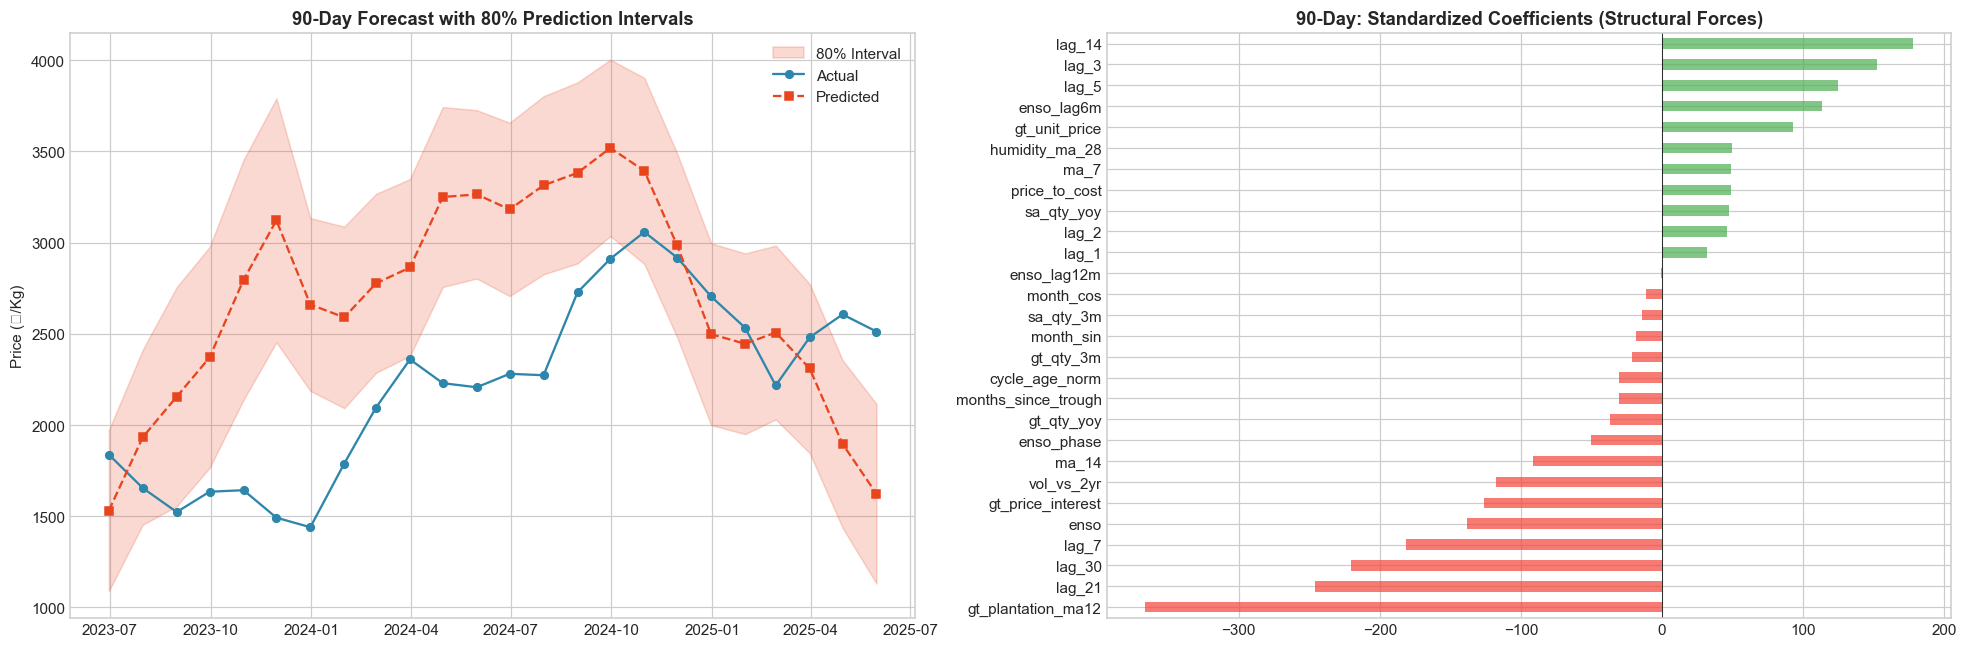

In [21]:
# === 90-day Visualization with uncertainty bands ===
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

if len(preds_90) > 0:
    ax = axes[0]
    ax.fill_between(preds_90['Date'], preds_90['Lo'], preds_90['Hi'], alpha=0.2, color='#E8451E', label='80% Interval')
    ax.plot(preds_90['Date'], preds_90['Actual'], 'o-', color='#2E86AB', markersize=5, label='Actual')
    ax.plot(preds_90['Date'], preds_90['Predicted'], 's--', color='#E8451E', markersize=5, label='Predicted')
    ax.set_title('90-Day Forecast with 80% Prediction Intervals', fontweight='bold')
    ax.legend()
    ax.set_ylabel('Price (₹/Kg)')

    # Coefficient interpretation
    ax = axes[1]
    # Retrain on all data for coefficient analysis
    X_all = d90[F90].dropna()
    y_all = d90.loc[X_all.index, 'target_3m']
    mask_all = ~y_all.isna()
    X_final = X_all[mask_all].values
    y_final = y_all[mask_all].values
    sc = StandardScaler()
    X_fs = sc.fit_transform(X_final)
    br_final = BayesianRidge()
    br_final.fit(X_fs, y_final)
    coefs = pd.Series(br_final.coef_, index=F90).sort_values()
    colors_c = ['#4CAF50' if c > 0 else '#F44336' for c in coefs.values]
    coefs.plot.barh(ax=ax, color=colors_c, alpha=0.7)
    ax.set_title('90-Day: Standardized Coefficients (Structural Forces)', fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

---
## Section 7: Regime Change Predictor

Target: >10% price decline within 6 months = bear signal.

In [22]:
# === Regime GBM Classifier with walk-forward CV ===
splits_reg = walk_forward_splits(len(d_regime), cfg_m['min_train'], cfg_m['step'], cfg_m['eval'], purge=6)

all_reg_results = []
all_reg_preds = []

for fold_i, (train_idx, test_idx) in enumerate(splits_reg):
    X_train = d_regime.iloc[train_idx][regime_feats].values
    y_train = d_regime.iloc[train_idx]['bear_signal'].values
    X_test = d_regime.iloc[test_idx][regime_feats].values
    y_test = d_regime.iloc[test_idx]['bear_signal'].values
    
    # Impute NaN with column median (better than dropping for sparse monthly data)
    from numpy import nanmedian
    col_medians = np.nanmedian(X_train, axis=0)
    col_medians = np.where(np.isnan(col_medians), 0, col_medians)
    X_tr = np.where(np.isnan(X_train), col_medians, X_train)
    y_tr = y_train
    X_te = np.where(np.isnan(X_test), col_medians, X_test)
    y_te = y_test
    
    if len(X_te) < 2 or y_tr.sum() < 2:
        continue
    
    m_cls = GradientBoostingClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.05,
        subsample=0.8, random_state=42)
    m_cls.fit(X_tr, y_tr)
    p_prob = m_cls.predict_proba(X_te)[:, 1] if len(m_cls.classes_) > 1 else np.zeros(len(y_te))
    
    metrics = {'fold': fold_i}
    if y_te.sum() > 0 and y_te.sum() < len(y_te):
        metrics['AUC'] = roc_auc_score(y_te, p_prob)
    else:
        metrics['AUC'] = np.nan
    metrics['n_test'] = len(y_te)
    metrics['n_bear'] = int(y_te.sum())
    all_reg_results.append(metrics)
    
    all_reg_preds.append(pd.DataFrame({
        'Date': d_regime.iloc[[test_idx[j] for j in range(len(test_idx)) if test_mask[j]]]['Date'].values,
        'Actual': y_te, 'Prob': p_prob, 'fold': fold_i
    }))

res_reg = pd.DataFrame(all_reg_results)
preds_reg = pd.concat(all_reg_preds, ignore_index=True) if all_reg_preds else pd.DataFrame()

print('REGIME CHANGE PREDICTOR — Walk-Forward Results')
print('='*60)
if len(res_reg) > 0:
    for _, r in res_reg.iterrows():
        print(f'  Fold {int(r["fold"])}: AUC = {r["AUC"]:.3f}, n={int(r["n_test"])}, bears={int(r["n_bear"])}' if not np.isnan(r['AUC']) else f'  Fold {int(r["fold"])}: AUC = N/A (no class variation)')
    print(f'\n  Mean AUC: {res_reg["AUC"].mean():.3f}')

REGIME CHANGE PREDICTOR — Walk-Forward Results
  Fold 0: AUC = N/A (no class variation)
  Fold 1: AUC = 1.000, n=6, bears=4
  Fold 2: AUC = N/A (no class variation)
  Fold 3: AUC = 0.125, n=6, bears=4
  Fold 4: AUC = 0.750, n=6, bears=2
  Fold 5: AUC = N/A (no class variation)
  Fold 6: AUC = N/A (no class variation)
  Fold 7: AUC = 0.750, n=6, bears=2
  Fold 8: AUC = N/A (no class variation)
  Fold 9: AUC = N/A (no class variation)
  Fold 10: AUC = 0.250, n=6, bears=4
  Fold 11: AUC = N/A (no class variation)

  Mean AUC: 0.575


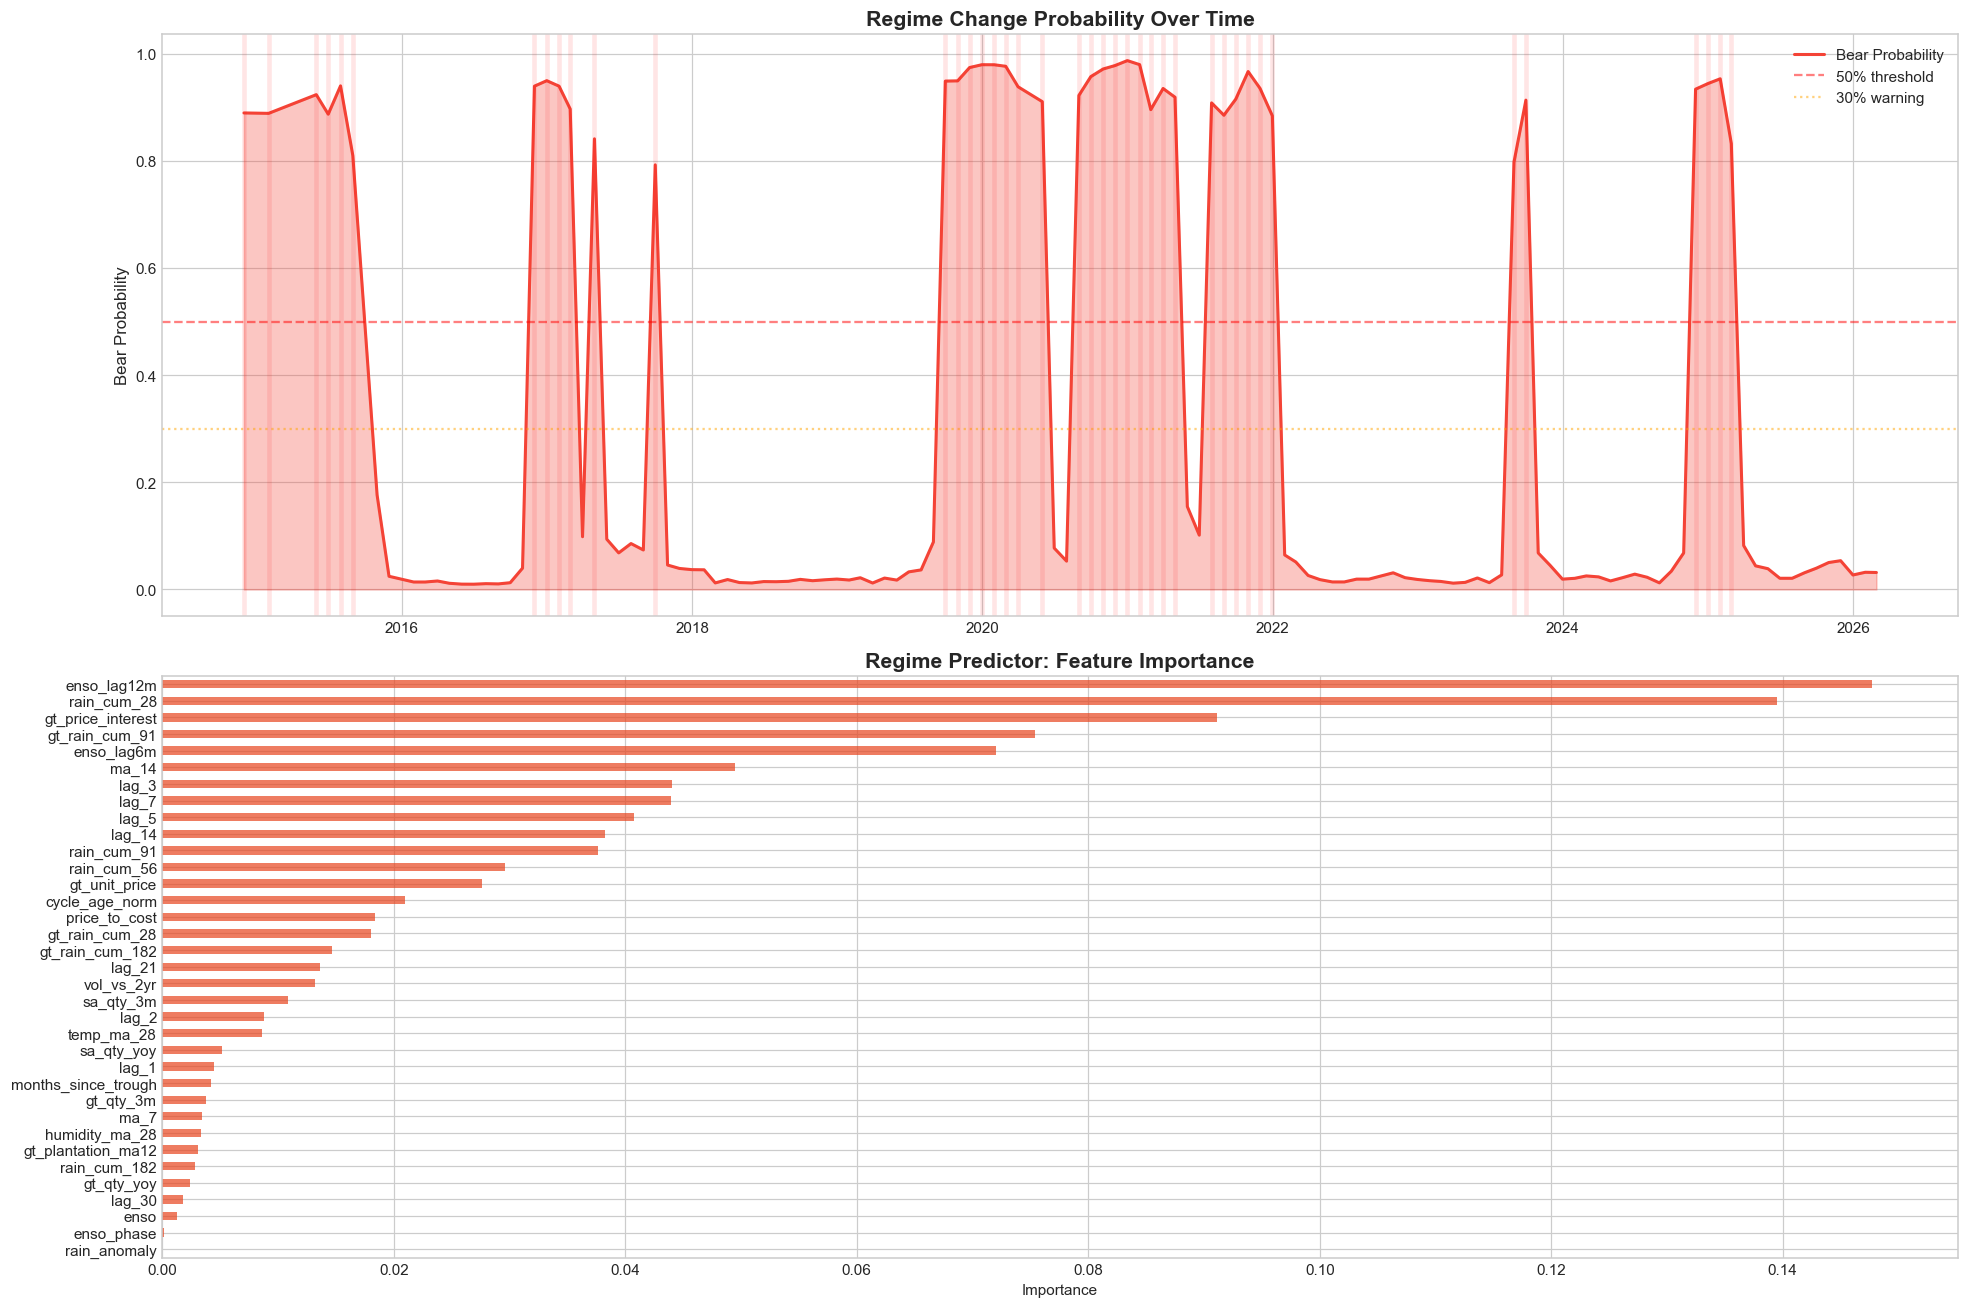


CURRENT REGIME ASSESSMENT (Feb 2026):
  Bear probability (next 6 months): 3.2%
  Risk level: 🟢 LOW


In [23]:
# === Regime: Full model + current assessment ===

# Train on all data
X_reg_all = d_regime[regime_feats].values
y_reg_all = d_regime['bear_signal'].values
X_reg_all = X_reg_all.astype(float)
col_med = np.nanmedian(X_reg_all, axis=0)
col_med = np.where(np.isnan(col_med), 0, col_med)
X_reg_clean = np.where(np.isnan(X_reg_all), col_med, X_reg_all)
y_reg_clean = y_reg_all
mask_reg = np.ones(len(X_reg_all), dtype=bool)  # keep all rows

m_reg_final = GradientBoostingClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.05,
    subsample=0.8, random_state=42)
m_reg_final.fit(X_reg_clean, y_reg_clean)

# Historical bear probability
probs_hist = m_reg_final.predict_proba(X_reg_clean)[:, 1] if len(m_reg_final.classes_) > 1 else np.zeros(len(y_reg_clean))
dates_hist = d_regime.iloc[np.where(mask_reg)[0]]['Date']

# Current regime assessment
latest = d_regime.iloc[-1]
latest_feats = latest[regime_feats].values.astype(float).reshape(1, -1)
latest_feats = np.where(np.isnan(latest_feats), col_med.reshape(1, -1), latest_feats)
try:
    current_prob = m_reg_final.predict_proba(latest_feats)[0, 1]
except:
    current_prob = np.nan

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Bear probability timeline
ax = axes[0]
ax.fill_between(dates_hist, 0, probs_hist, alpha=0.3, color='#F44336')
ax.plot(dates_hist, probs_hist, color='#F44336', linewidth=2, label='Bear Probability')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.axhline(y=0.3, color='orange', linestyle=':', alpha=0.5, label='30% warning')
# Mark actual bear periods
bear_dates = d_regime.iloc[np.where(mask_reg)[0]]
bear_actual = bear_dates[bear_dates['bear_signal'] == 1]['Date']
for bd in bear_actual:
    ax.axvline(x=bd, color='red', alpha=0.1, linewidth=3)
ax.set_ylabel('Bear Probability', fontsize=11)
ax.set_title('Regime Change Probability Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)

# Feature importance for regime model
ax = axes[1]
imp_reg = pd.Series(m_reg_final.feature_importances_, index=regime_feats).sort_values(ascending=True)
imp_reg.plot.barh(ax=ax, color='#E8451E', alpha=0.7)
ax.set_title('Regime Predictor: Feature Importance', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

print(f'\nCURRENT REGIME ASSESSMENT ({latest["Date"].strftime("%b %Y")}):')
print(f'  Bear probability (next 6 months): {current_prob:.1%}' if not np.isnan(current_prob) else '  Bear probability: N/A')
print(f'  Risk level: {"🔴 HIGH" if current_prob > 0.5 else "🟡 MODERATE" if current_prob > 0.3 else "🟢 LOW"}'
      if not np.isnan(current_prob) else '')

---
## Section 8: Unified Dashboard & Forward Forecasts

In [24]:
# === Retrain all models on full data + generate forward forecasts ===

# 7-day
m7_final = lgb_7d()
X7 = d7[F7].values
y7 = d7['target_7d'].values
mask7 = ~np.isnan(X7).any(axis=1) & ~np.isnan(y7)
m7_final.fit(X7[mask7], y7[mask7])
# Current 7d forecast: use latest available features
latest_7d = d[F7].dropna().iloc[-1:].values
forecast_7d = m7_final.predict(latest_7d)[0] if len(latest_7d) > 0 else np.nan

# 14-day
m14_final = lgb_14d()
X14 = d14[F14].values
y14 = d14['target_14d'].values
mask14 = ~np.isnan(X14).any(axis=1) & ~np.isnan(y14)
m14_final.fit(X14[mask14], y14[mask14])
latest_14d = d[F14].dropna().iloc[-1:].values
forecast_14d = m14_final.predict(latest_14d)[0] if len(latest_14d) > 0 else np.nan

# 28-day (stacked)
X28 = d28[F28_SEL].values
y28 = d28['target_4w'].values
mask28 = ~np.isnan(X28).any(axis=1) & ~np.isnan(y28)
m28_lgb = GradientBoostingRegressor(n_estimators=150, max_depth=4, learning_rate=0.05,
                              subsample=0.8, min_samples_leaf=10, random_state=42)
m28_lgb.fit(X28[mask28], y28[mask28])
sc28 = StandardScaler()
X28_s = sc28.fit_transform(X28[mask28])
m28_ridge = Ridge(alpha=10.0)
m28_ridge.fit(X28_s, y28[mask28])
latest_28d = weekly[F28_SEL].dropna().iloc[-1:].values
if len(latest_28d) > 0:
    p28_l = m28_lgb.predict(latest_28d)[0]
    p28_r = m28_ridge.predict(sc28.transform(latest_28d))[0]
    forecast_28d = 0.6 * p28_l + 0.4 * p28_r
else:
    forecast_28d = np.nan

# 90-day
X90 = d90[F90].dropna().values
y90_idx = d90[F90].dropna().index
y90 = d90.loc[y90_idx, 'target_3m'].values
mask90 = ~np.isnan(y90)
sc90 = StandardScaler()
X90_s = sc90.fit_transform(X90[mask90])
m90_final = BayesianRidge()
m90_final.fit(X90_s, y90[mask90])
latest_90d = d90[F90].dropna().iloc[-1:].values
if len(latest_90d) > 0:
    p90_mean, p90_std = m90_final.predict(sc90.transform(latest_90d), return_std=True)
    forecast_90d = p90_mean[0]
    forecast_90d_lo = p90_mean[0] - 1.28 * p90_std[0]
    forecast_90d_hi = p90_mean[0] + 1.28 * p90_std[0]
else:
    forecast_90d = forecast_90d_lo = forecast_90d_hi = np.nan

current_price = d['AvgPrice'].iloc[-1]
current_date = d['Date'].iloc[-1]

print('FORWARD FORECASTS')
print('='*60)
print(f'Current Price: ₹{current_price:,.0f}/Kg ({current_date.strftime("%d %b %Y")})')
print(f'  7-day:  ₹{forecast_7d:,.0f} ({(forecast_7d/current_price-1)*100:+.1f}%)')
print(f'  14-day: ₹{forecast_14d:,.0f} ({(forecast_14d/current_price-1)*100:+.1f}%)')
print(f'  28-day: ₹{forecast_28d:,.0f} ({(forecast_28d/current_price-1)*100:+.1f}%)')
print(f'  90-day: ₹{forecast_90d:,.0f} ({(forecast_90d/current_price-1)*100:+.1f}%) [Range: ₹{forecast_90d_lo:,.0f} - ₹{forecast_90d_hi:,.0f}]')
print(f'  Regime risk: {current_prob:.0%} bear probability (next 6 months)')

FORWARD FORECASTS
Current Price: ₹2,505/Kg (06 Feb 2026)
  7-day:  ₹2,455 (-2.0%)
  14-day: ₹2,420 (-3.4%)
  28-day: ₹2,427 (-3.1%)
  90-day: ₹2,096 (-16.3%) [Range: ₹1,688 - ₹2,505]
  Regime risk: 3% bear probability (next 6 months)


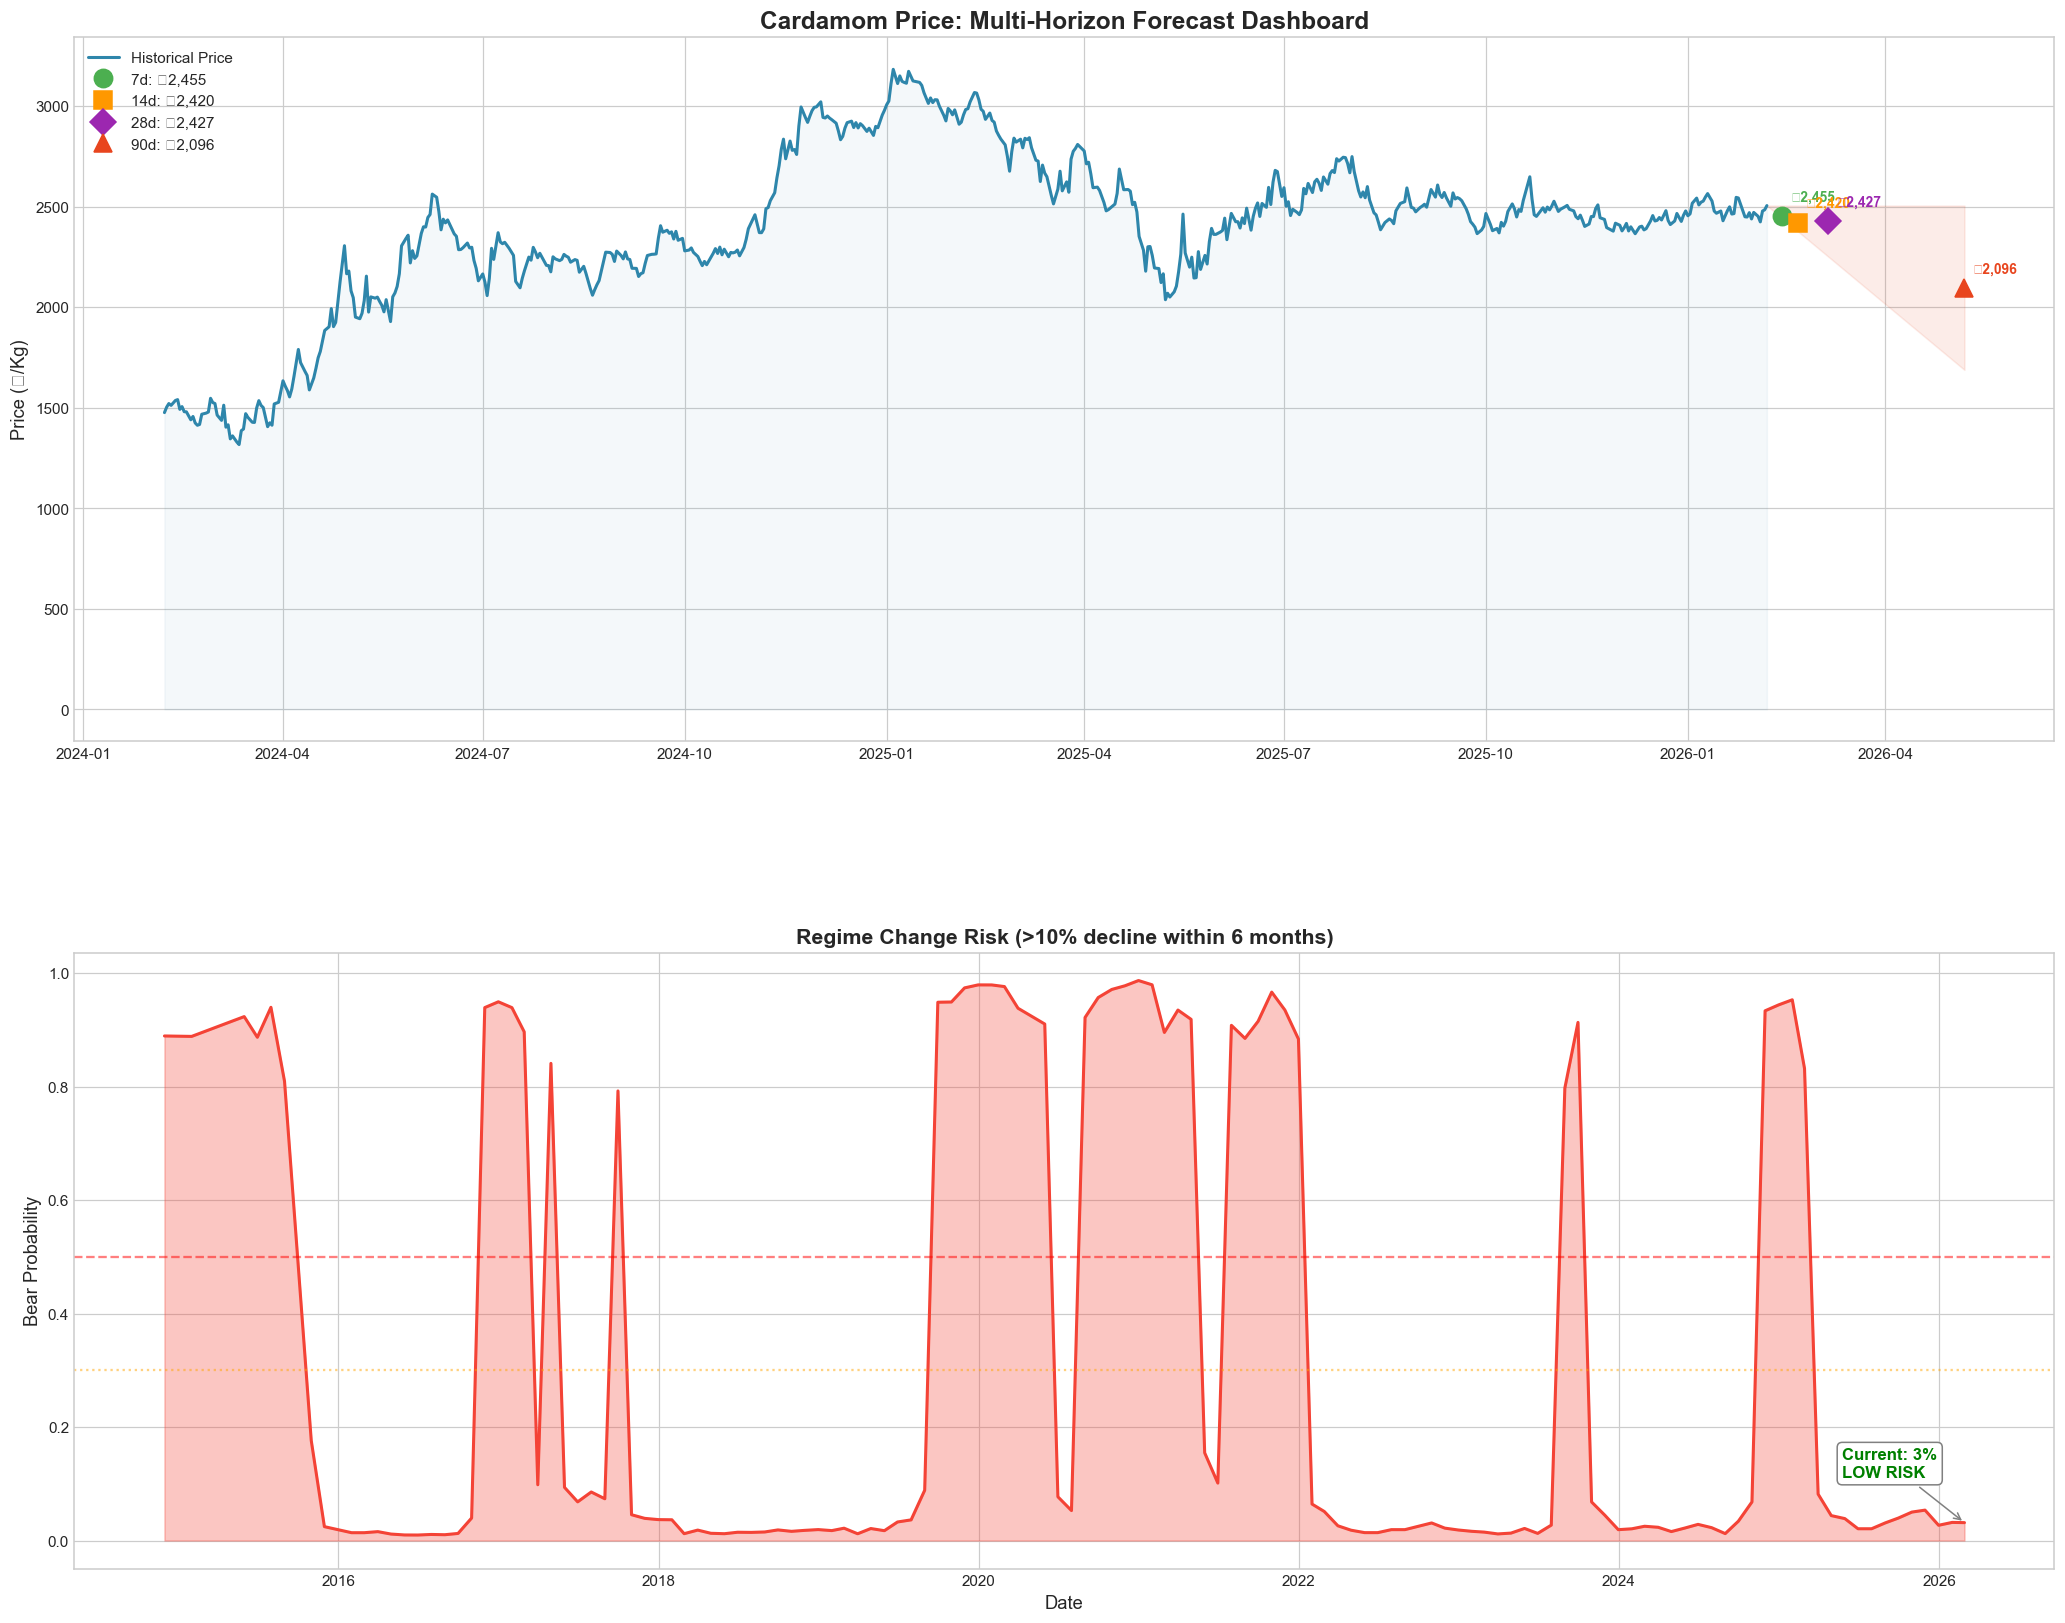

In [25]:
# === Master Dashboard Visualization ===
fig = plt.figure(figsize=(20, 16))

# Top: Price history + forward forecasts
ax1 = fig.add_axes([0.05, 0.55, 0.90, 0.40])
# Last 2 years of history
cutoff = current_date - pd.Timedelta(days=730)
recent = d[d['Date'] >= cutoff]
ax1.plot(recent['Date'], recent['AvgPrice'], color='#2E86AB', linewidth=2, label='Historical Price')
ax1.fill_between(recent['Date'], 0, recent['AvgPrice'], alpha=0.05, color='#2E86AB')

# Plot forecasts as points extending forward
forecast_points = [
    (current_date + pd.Timedelta(days=7), forecast_7d, '7d', '#4CAF50', 'o'),
    (current_date + pd.Timedelta(days=14), forecast_14d, '14d', '#FF9800', 's'),
    (current_date + pd.Timedelta(days=28), forecast_28d, '28d', '#9C27B0', 'D'),
    (current_date + pd.Timedelta(days=90), forecast_90d, '90d', '#E8451E', '^'),
]
for date, price, label, color, marker in forecast_points:
    if not np.isnan(price):
        ax1.plot(date, price, marker, color=color, markersize=12, zorder=5, label=f'{label}: ₹{price:,.0f}')
        ax1.annotate(f'₹{price:,.0f}', xy=(date, price), xytext=(5, 10),
                     textcoords='offset points', fontsize=9, color=color, fontweight='bold')

# 90-day uncertainty band
if not np.isnan(forecast_90d_lo):
    ax1.fill_between([current_date, current_date + pd.Timedelta(days=90)],
                     [current_price, forecast_90d_lo], [current_price, forecast_90d_hi],
                     alpha=0.1, color='#E8451E')

ax1.set_ylabel('Price (₹/Kg)', fontsize=12)
ax1.set_title('Cardamom Price: Multi-Horizon Forecast Dashboard', fontsize=16, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')

# Bottom: Regime probability
ax2 = fig.add_axes([0.05, 0.08, 0.90, 0.35])
ax2.fill_between(dates_hist, 0, probs_hist, alpha=0.3, color='#F44336')
ax2.plot(dates_hist, probs_hist, color='#F44336', linewidth=2)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax2.axhline(y=0.3, color='orange', linestyle=':', alpha=0.5)
ax2.set_ylabel('Bear Probability', fontsize=12)
ax2.set_title('Regime Change Risk (>10% decline within 6 months)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)

# Annotate current
if not np.isnan(current_prob):
    ax2.annotate(f'Current: {current_prob:.0%}\n{"HIGH RISK" if current_prob > 0.5 else "MODERATE" if current_prob > 0.3 else "LOW RISK"}',
                 xy=(dates_hist.iloc[-1], probs_hist[-1]),
                 xytext=(-80, 30), textcoords='offset points',
                 fontsize=11, fontweight='bold',
                 color='red' if current_prob > 0.5 else 'orange' if current_prob > 0.3 else 'green',
                 bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'),
                 arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

In [26]:
# === Model Card Summary ===
print()
print('╔' + '═'*78 + '╗')
print('║' + ' CARDAMOM FORECASTING FRAMEWORK — MODEL CARD'.center(78) + '║')
print('╠' + '═'*78 + '╣')
print('║' + f' Current Price: ₹{current_price:,.0f}/Kg ({current_date.strftime("%d %b %Y")})'.ljust(78) + '║')
print('╠' + '═'*78 + '╣')

headers = f'{"Horizon":<10} {"Model":<20} {"WF-MAE":<10} {"WF-MAPE":<10} {"Dir.Acc":<10} {"Forecast":<15}'
print('║ ' + headers.ljust(77) + '║')
print('║ ' + '-'*77 + '║')

rows = [
    ('7-day', 'LightGBM', res_7d['MAE'].mean(), res_7d['MAPE'].mean(), 
     res_7d.get('DirAcc', pd.Series([0])).mean(), f'₹{forecast_7d:,.0f}'),
    ('14-day', 'LightGBM', res_14d['MAE'].mean(), res_14d['MAPE'].mean(),
     res_14d.get('DirAcc', pd.Series([0])).mean(), f'₹{forecast_14d:,.0f}'),
]
if len(res_28) > 0:
    rows.append(('28-day', 'LGB+Ridge Stack', res_28['MAE'].mean(), res_28['MAPE'].mean(),
                 res_28.get('DirAcc', pd.Series([0])).mean(), f'₹{forecast_28d:,.0f}'))
if len(res_90) > 0:
    rows.append(('90-day', 'Bayesian Ridge', res_90['MAE'].mean(), res_90['MAPE'].mean(),
                 0, f'₹{forecast_90d:,.0f} [{forecast_90d_lo:,.0f}-{forecast_90d_hi:,.0f}]'))

for name, model, mae, mape, da, fc in rows:
    row = f'{name:<10} {model:<20} {mae:<10.1f} {mape:<9.1f}% {da:<9.0f}% {fc:<15}'
    print('║ ' + row.ljust(77) + '║')

print('╠' + '═'*78 + '╣')
reg_str = f' Regime Risk: {current_prob:.0%} bear probability | ' + ('🔴 HIGH' if current_prob > 0.5 else '🟡 MODERATE' if current_prob > 0.3 else '🟢 LOW') if not np.isnan(current_prob) else ' Regime Risk: N/A'
print('║' + reg_str.ljust(78) + '║')
print('╚' + '═'*78 + '╝')

print()
print('KEY INDICATORS TO WATCH:')
imp_reg_sorted = pd.Series(m_reg_final.feature_importances_, index=regime_feats).sort_values(ascending=False)
for i, (feat, imp) in enumerate(imp_reg_sorted.head(5).items()):
    val = latest[feat] if feat in latest.index and not pd.isna(latest[feat]) else 'N/A'
    print(f'  {i+1}. {feat}: current = {val:.2f} (importance: {imp:.3f})' if isinstance(val, (int, float)) else f'  {i+1}. {feat}: {val} (importance: {imp:.3f})')


╔══════════════════════════════════════════════════════════════════════════════╗
║                  CARDAMOM FORECASTING FRAMEWORK — MODEL CARD                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Current Price: ₹2,505/Kg (06 Feb 2026)                                       ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Horizon    Model                WF-MAE     WF-MAPE    Dir.Acc    Forecast       ║
║ -----------------------------------------------------------------------------║
║ 7-day      LightGBM             202.0      11.4     % 52       % ₹2,455         ║
║ 14-day     LightGBM             266.6      15.0     % 50       % ₹2,420         ║
║ 28-day     LGB+Ridge Stack      316.1      12.1     % 51       % ₹2,427         ║
║ 90-day     Bayesian Ridge       666.0      33.9     % 0        % ₹2,096 [1,688-2,505]║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Regim

## Section 9: Forecast Validation — Predicted vs Actual

The model was trained on data through **Feb 6, 2026** (base price: ₹2,505/Kg).  
Actual auction prices from **Feb 7–18, 2026** were collected from the Spices Board of India  
to validate the 7-day and (partial) 14-day forecasts.

In [ ]:
# === Forecast Validation: Actual vs Predicted ===
# Actual prices from Spices Board of India e-auction data (Feb 7-18, 2026)
# Source: indianspices.com / cardamom.auction

actual_post = pd.DataFrame({
    'Date': pd.to_datetime([
        '2026-02-07', '2026-02-09', '2026-02-10', '2026-02-11',
        '2026-02-12', '2026-02-13', '2026-02-14',
        '2026-02-16', '2026-02-17', '2026-02-18'
    ]),
    'AvgPrice': [2528, 2512, 2462, 2449, 2501, 2476, 2448, 2422, 2435, 2440]
})

# Combine with pre-forecast data for plotting context
pre_forecast = daily.loc[daily['Date'] >= '2026-01-01', ['Date', 'AvgPrice']].copy()
all_prices = pd.concat([pre_forecast, actual_post], ignore_index=True).sort_values('Date')

# Forecast points
base_date = pd.Timestamp('2026-02-06')
base_price = 2505

forecasts = pd.DataFrame({
    'Horizon':  ['7-day',  '14-day', '28-day', '90-day'],
    'Date':     [base_date + pd.Timedelta(days=d) for d in [7, 14, 28, 90]],
    'Predicted': [2455, 2420, 2427, 2096],
})

# Find closest actual for each forecast date
for i, row in forecasts.iterrows():
    mask = actual_post['Date'] == row['Date']
    if mask.any():
        forecasts.loc[i, 'Actual'] = actual_post.loc[mask, 'AvgPrice'].values[0]
        forecasts.loc[i, 'Status'] = 'Confirmed'
    else:
        # Use closest available date within 2 days
        diffs = (actual_post['Date'] - row['Date']).abs()
        closest_idx = diffs.idxmin()
        if diffs[closest_idx] <= pd.Timedelta(days=2):
            forecasts.loc[i, 'Actual'] = actual_post.loc[closest_idx, 'AvgPrice']
            forecasts.loc[i, 'Status'] = f"Proxy ({actual_post.loc[closest_idx, 'Date'].strftime('%b %d')})"
        else:
            forecasts.loc[i, 'Actual'] = np.nan
            forecasts.loc[i, 'Status'] = 'Not yet available'

forecasts['Error'] = forecasts['Actual'] - forecasts['Predicted']
forecasts['MAPE_%'] = (abs(forecasts['Error']) / forecasts['Actual'] * 100).round(2)
forecasts['Direction'] = ''
for i, row in forecasts.iterrows():
    if pd.notna(row['Actual']):
        pred_dir = 'down' if row['Predicted'] < base_price else 'up'
        actual_dir = 'down' if row['Actual'] < base_price else 'up'
        forecasts.loc[i, 'Direction'] = 'Correct' if pred_dir == actual_dir else 'Wrong'

# Print validation table
print('=' * 85)
print(' FORECAST VALIDATION: Predicted vs Actual (Base: Feb 6, 2026 @ Rs 2,505/Kg)')
print('=' * 85)
print(f"{'Horizon':<10} {'Target':<12} {'Predicted':>10} {'Actual':>10} {'Error':>8} {'MAPE':>7} {'Dir':>8}  Status")
print('-' * 85)
for _, r in forecasts.iterrows():
    actual_str = f"{r['Actual']:.0f}" if pd.notna(r['Actual']) else '—'
    error_str = f"{r['Error']:+.0f}" if pd.notna(r['Error']) else '—'
    mape_str = f"{r['MAPE_%']:.1f}%" if pd.notna(r['MAPE_%']) else '—'
    dir_str = r['Direction'] if r['Direction'] else '—'
    print(f"{r['Horizon']:<10} {r['Date'].strftime('%b %d'):<12} {r['Predicted']:>10,.0f} {actual_str:>10} {error_str:>8} {mape_str:>7} {dir_str:>8}  {r['Status']}")
print('=' * 85)
print()

# Summary statistics for validated horizons
validated = forecasts.dropna(subset=['Actual'])
if len(validated) > 0:
    avg_mape = validated['MAPE_%'].mean()
    avg_abs_error = validated['Error'].abs().mean()
    dir_correct = (validated['Direction'] == 'Correct').sum()
    dir_total = len(validated)
    print(f'Validated forecasts: {len(validated)} of {len(forecasts)}')
    print(f'Average absolute error: Rs {avg_abs_error:.0f}/Kg')
    print(f'Average MAPE: {avg_mape:.1f}%')
    print(f'Directional accuracy: {dir_correct}/{dir_total}')
    print()

# Price path since forecast
print('Post-forecast price path (Feb 7-18, 2026):')
for _, r in actual_post.iterrows():
    change = r['AvgPrice'] - base_price
    pct = change / base_price * 100
    bar = '+' * max(0, int(pct*5)) + '-' * max(0, int(-pct*5))
    print(f"  {r['Date'].strftime('%b %d')} ({r['Date'].strftime('%a')}): Rs {r['AvgPrice']:,.0f}  ({change:+.0f}, {pct:+.1f}%)  {bar}")

In [ ]:
# === Validation Plot: Actual Price Path vs Forecast Points ===
fig, ax = plt.subplots(figsize=(16, 7))

# Pre-forecast actuals (from dataset)
pre = all_prices[all_prices['Date'] <= base_date]
ax.plot(pre['Date'], pre['AvgPrice'], 'b-o', markersize=4, label='Actual (pre-forecast)', zorder=3)

# Post-forecast actuals (from Spices Board)
post = all_prices[all_prices['Date'] > base_date]
ax.plot(post['Date'], post['AvgPrice'], 'g-o', markersize=5, label='Actual (post-forecast)', zorder=4)

# Base point
ax.scatter([base_date], [base_price], color='black', s=150, zorder=6, marker='D', label=f'Forecast base (Feb 6: Rs {base_price:,})')

# Forecast points
for _, r in forecasts.iterrows():
    color = 'limegreen' if r.get('Direction') == 'Correct' else ('red' if r.get('Direction') == 'Wrong' else 'orange')
    if pd.notna(r['Actual']):
        ax.scatter([r['Date']], [r['Predicted']], color=color, s=200, zorder=7, marker='*',
                   edgecolors='black', linewidths=0.5)
        ax.annotate(f"{r['Horizon']}\nPred: {r['Predicted']:,.0f}\nActual: {r['Actual']:,.0f}\nErr: {r['MAPE_%']:.1f}%",
                    xy=(r['Date'], r['Predicted']), xytext=(10, 20),
                    textcoords='offset points', fontsize=8, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3),
                    arrowprops=dict(arrowstyle='->', color='gray'))
    else:
        ax.scatter([r['Date']], [r['Predicted']], color='orange', s=150, zorder=7, marker='*',
                   edgecolors='black', linewidths=0.5)
        ax.annotate(f"{r['Horizon']}\nPred: {r['Predicted']:,.0f}\n(awaiting actual)",
                    xy=(r['Date'], r['Predicted']), xytext=(10, -30),
                    textcoords='offset points', fontsize=8, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='gray'))

# Forecast date vertical line
ax.axvline(base_date, color='red', linestyle='--', alpha=0.5, label='Forecast date')
ax.axhspan(base_price * 0.95, base_price * 1.05, color='blue', alpha=0.05, label='±5% band')

ax.set_title('Cardamom Price Forecast Validation\nPredicted vs Actual (Feb 2026)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Price (Rs/Kg)')
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\nNote: 28-day (Mar 6) and 90-day (May 7) forecasts await future data for validation.')